In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Oct 31st, 2023
current_version = 8 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))#,'AE_267']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching files for AE_239
Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
Fetching files for AE_301
Fetching files for AE_312
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.txt: No columns to parse from file
Error loading P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
P:\Behavioor\BS_123\

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

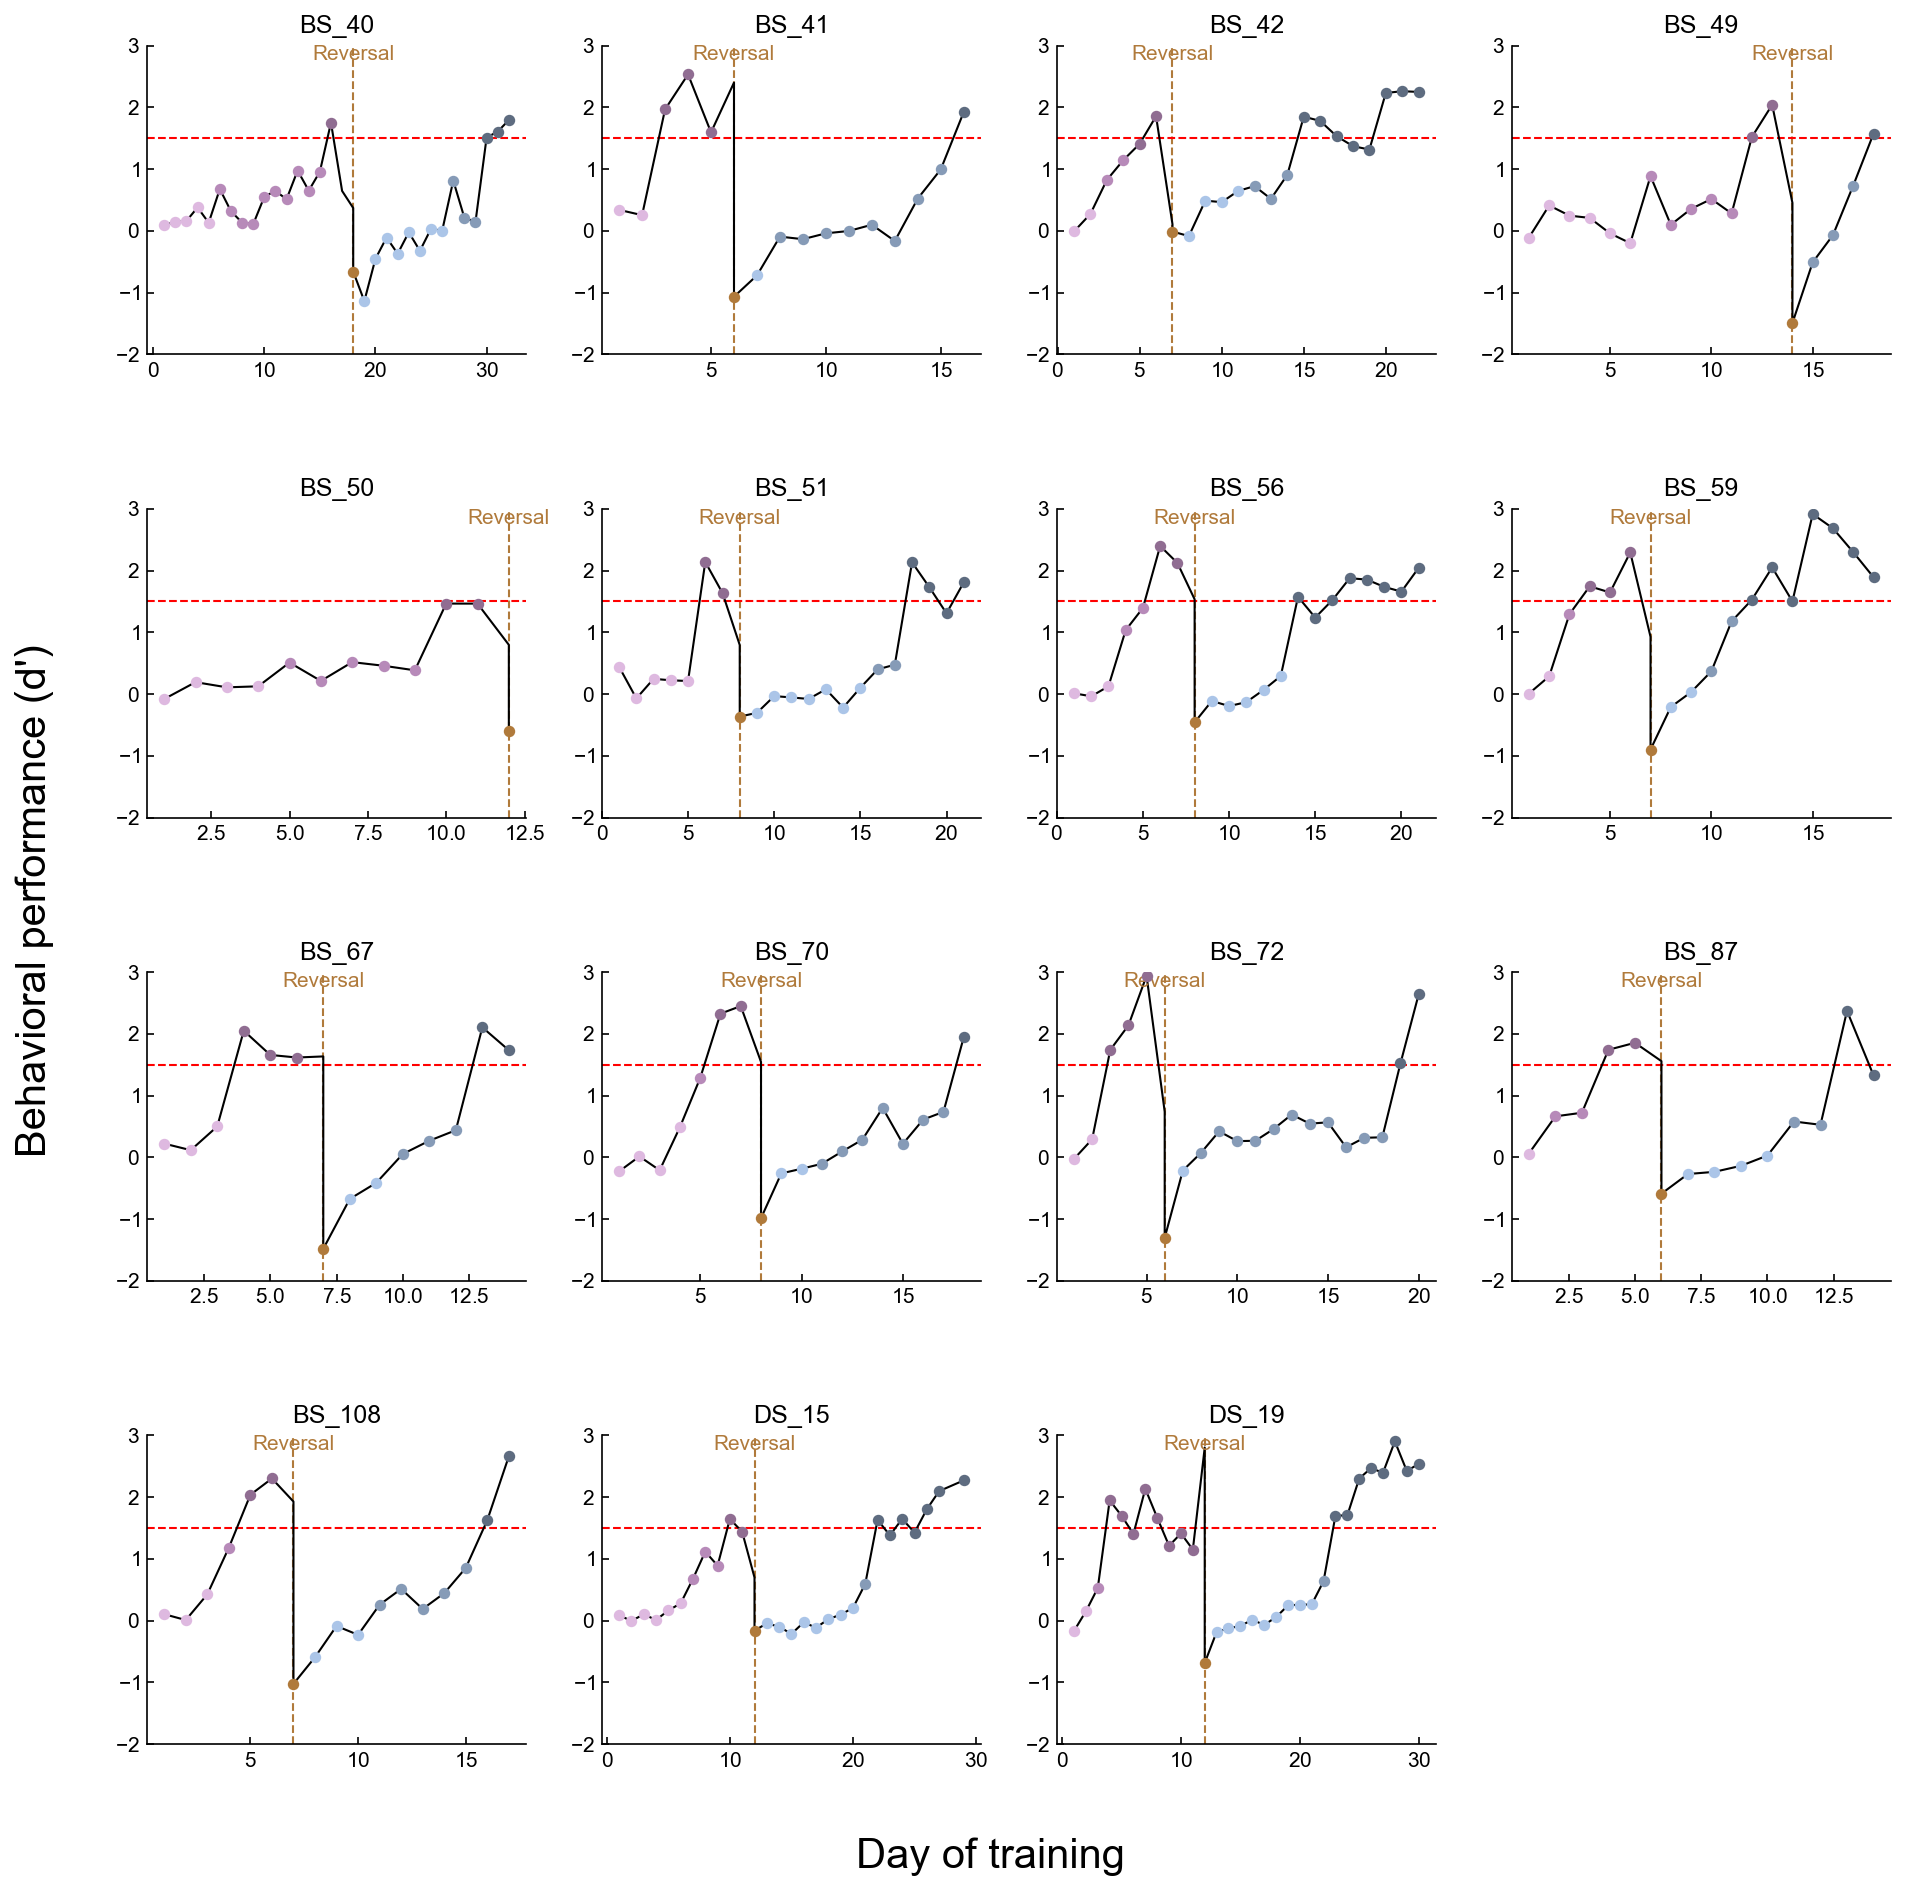

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:11<00:00, 65.65it/s] 


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:29<00:00, 61.40it/s] 

errors for: []


In [7]:
print(animals)
animal = 'DS_19'

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19']


In [8]:
print(animalBehaviors[animal].reversal)
print()
for session in tqdm(np.unique(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.animal == animal:
        print(sessionfile.meta.day_of_training)

  6%|▌         | 8/132 [00:00<00:01, 71.41it/s]

12



 95%|█████████▍| 125/132 [00:01<00:00, 125.26it/s]

20
21
22
24
26
28
29
11
30
12
13
14
15


100%|██████████| 132/132 [00:01<00:00, 100.97it/s]

16
17
18
19


In [8]:
['BS_40', 'BS_41', 'BS_42', 'BS_70', 'BS_72', 'BS_108', 'DS_15', 'DS_19']

['BS_40', 'BS_41', 'BS_42', 'BS_70', 'BS_72', 'BS_108', 'DS_15', 'DS_19']

In [11]:
for session in tqdm(np.unique(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.day_of_training != control_animal_days[sessionfile.meta.animal]:
        continue
        
    print(f"{sessionfile.meta.animal} day {sessionfile.meta.day_of_training} is from phase {learning_phases[sessionfile.meta.animal]}")

 16%|█▌        | 21/131 [00:00<00:01, 104.88it/s]

BS_108 day 6 is from phase namespace(post_early_days=array([ 8,  9, 10]), post_expert_days=array([16, 17]), post_late_days=array([11, 12, 13, 14, 15]), pre_early_days=array([1, 2, 3]), pre_expert_days=array([5, 6]), pre_late_days=array([4]), second_early_days=[], second_expert_days=[], second_late_days=[])


 76%|███████▋  | 100/131 [00:00<00:00, 123.81it/s]

BS_72 day 5 is from phase namespace(post_early_days=array([7]), post_expert_days=array([19, 20]), post_late_days=array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), pre_early_days=array([1, 2]), pre_expert_days=array([3, 4, 5]), pre_late_days=array([], dtype=int32), second_early_days=[], second_expert_days=[], second_late_days=[])
BS_87 day 5 is from phase namespace(post_early_days=array([ 7,  8,  9, 10]), post_expert_days=array([13, 14]), post_late_days=array([11, 12]), pre_early_days=array([1]), pre_expert_days=array([4, 5]), pre_late_days=array([2, 3]), second_early_days=[], second_expert_days=[], second_late_days=[])


100%|██████████| 131/131 [00:01<00:00, 95.39it/s] 


In [458]:
#108 - good - pre expert
#40 - Has drift - use 10 instead - pre late
#49 - Has lots of drift - use 11 instead - pre late
#50 - Minor drift if anything - pre late
#70 - Has drift - especially later in session - no other options
#72 - Drift early in recording. Probably handled by removing first 100 trials (200s of drift) - pre expert
#87 - good - pre expert
#15 - has drift spikes
#19 - has slow drift across session

In [12]:
# Pick last day of pre-reversal

control_animal_days = dict()
control_animal_days['BS_40'] = np.nan#10#16
control_animal_days['BS_41'] = np.nan
control_animal_days['BS_42'] = np.nan
control_animal_days['BS_49'] = np.nan#11#13
control_animal_days['BS_50'] = np.nan#9
control_animal_days['BS_51'] = np.nan
control_animal_days['BS_56'] = np.nan
### No data for 59
control_animal_days['BS_67'] = np.nan
control_animal_days['BS_70'] = np.nan#5
control_animal_days['BS_72'] = 5
control_animal_days['BS_87'] = 5
control_animal_days['BS_108'] = 6
control_animal_days['DS_15'] = np.nan#11# Use this???
control_animal_days['DS_19'] = np.nan#11# Use this???

In [13]:
switch_pre_FR = []
switch_post_FR = []
switch_pre_FR_bl = []
switch_post_FR_bl = []
switch_pre_FR_5k = []
switch_pre_FR_11k = []
switch_post_FR_5k = []
switch_post_FR_11k = []
switch_pre_FR_hit = []
switch_post_FR_hit = []
switch_pre_FR_miss = []
switch_post_FR_miss = []
switch_pre_FR_falarm = []
switch_post_FR_falarm = []
switch_pre_FR_creject = []
switch_post_FR_creject = []

switch_animals = []

subset = 'all'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animal = sessionfile.meta.animal
    day = sessionfile.meta.day_of_training
        
    if EILphases[idx] not in ['switch']:
        continue
    
    allConditions = ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded='NO_TRIM')
    this_FR_pre = []
    this_FR_pre_bl = []
    pre_switch_trials = allConditions['pre_switch'].trials
    pre_switch_trials = pre_switch_trials[np.greater_equal(pre_switch_trials,100)]
    for trial in pre_switch_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre.append(FR)
        
        ###############################################################################################
        
        trialStart = sessionfile.trials.starts[trial] - 0.2 * sessionfile.meta.fs
        trialEnd = sessionfile.trials.starts[trial]
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_bl.append(FR)
        
    this_FR_post = []
    this_FR_post_bl = []
    post_switch_trials = allConditions['post_switch'].trials
    post_switch_trials = post_switch_trials[np.less(post_switch_trials,300)]
    for trial in post_switch_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post.append(FR)
        
        ###############################################################################################
        
        trialStart = sessionfile.trials.starts[trial] - 0.2 * sessionfile.meta.fs
        trialEnd = sessionfile.trials.starts[trial]
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_bl.append(FR)
        
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    
    this_FR_pre_5k = []
    pre_switch_nontarget_trials = allConditions['pre_switch_nontarget'].trials
    pre_switch_nontarget_trials = pre_switch_nontarget_trials[np.greater_equal(pre_switch_nontarget_trials,100)]
    for trial in pre_switch_nontarget_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_5k.append(FR)
        
    this_FR_pre_11k = []
    pre_switch_target_trials = allConditions['pre_switch_target'].trials
    pre_switch_target_trials = pre_switch_target_trials[np.greater_equal(pre_switch_target_trials,100)]
    for trial in pre_switch_target_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_11k.append(FR)
        
    this_FR_post_5k = []
    post_switch_target_trials = allConditions['post_switch_target'].trials
    post_switch_target_trials = post_switch_target_trials[np.less(post_switch_target_trials,300)]
    for trial in post_switch_target_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_5k.append(FR)
        
    this_FR_post_11k = []
    post_switch_nontarget_trials = allConditions['post_switch_nontarget'].trials
    post_switch_nontarget_trials = post_switch_nontarget_trials[np.less(post_switch_nontarget_trials,300)]
    for trial in post_switch_nontarget_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_11k.append(FR)

    
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    
    this_FR_pre_hit = []
    pre_switch_hit_trials = allConditions['pre_switch_hit'].trials
    pre_switch_hit_trials = pre_switch_hit_trials[np.greater_equal(pre_switch_hit_trials,100)]
    for trial in pre_switch_hit_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_hit.append(FR)
        
    this_FR_pre_miss = []
    pre_switch_miss_trials = allConditions['pre_switch_miss'].trials
    pre_switch_miss_trials = pre_switch_miss_trials[np.greater_equal(pre_switch_miss_trials,100)]
    for trial in pre_switch_miss_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_miss.append(FR)
        
    this_FR_pre_falarm = []
    pre_switch_falarm_trials = allConditions['pre_switch_falarm'].trials
    pre_switch_falarm_trials = pre_switch_falarm_trials[np.greater_equal(pre_switch_falarm_trials,100)]
    for trial in pre_switch_falarm_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_falarm.append(FR)
        
    this_FR_pre_creject = []
    pre_switch_creject_trials = allConditions['pre_switch_creject'].trials
    pre_switch_creject_trials = pre_switch_creject_trials[np.greater_equal(pre_switch_creject_trials,100)]
    for trial in pre_switch_creject_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_creject.append(FR)
        
    this_FR_post_hit = []
    post_switch_hit_trials = allConditions['post_switch_hit'].trials
    post_switch_hit_trials = post_switch_hit_trials[np.less(post_switch_hit_trials,300)]
    for trial in post_switch_hit_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_hit.append(FR)
        
    this_FR_post_miss = []
    post_switch_miss_trials = allConditions['post_switch_miss'].trials
    post_switch_miss_trials = post_switch_miss_trials[np.less(post_switch_miss_trials,300)]
    for trial in post_switch_miss_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_miss.append(FR)
        
    this_FR_post_falarm = []
    post_switch_falarm_trials = allConditions['post_switch_falarm'].trials
    post_switch_falarm_trials = post_switch_falarm_trials[np.less(post_switch_falarm_trials,300)]
    for trial in post_switch_falarm_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_falarm.append(FR)
        
    this_FR_post_creject = []
    post_switch_creject_trials = allConditions['post_switch_creject'].trials
    post_switch_creject_trials = post_switch_creject_trials[np.less(post_switch_creject_trials,300)]
    for trial in post_switch_creject_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_creject.append(FR)
        
        
        

    diff_5 = np.mean(this_FR_post_5k)-np.mean(this_FR_pre_5k)
    if subset == 'all' or (subset=='up' and diff_5 > 0) or (subset=='down' and diff_5 < 0):
        switch_pre_FR_5k.append(np.mean(this_FR_pre_5k))
        switch_post_FR_5k.append(np.mean(this_FR_post_5k))
    
    diff_11 = np.mean(this_FR_post_11k)-np.mean(this_FR_pre_11k)
    if subset == 'all' or (subset=='up' and diff_11 > 0) or (subset=='down' and diff_11 < 0):
        switch_pre_FR_11k.append(np.mean(this_FR_pre_11k))
        switch_post_FR_11k.append(np.mean(this_FR_post_11k))
        
    ### Haven't set the rest of these up for separate up/down modulation
    switch_pre_FR.append(np.mean(this_FR_pre))
    switch_pre_FR_bl.append(np.mean(this_FR_pre_bl))
    switch_post_FR.append(np.mean(this_FR_post))
    switch_post_FR_bl.append(np.mean(this_FR_post_bl))
    
    switch_pre_FR_hit.append(np.mean(this_FR_pre_hit))
    switch_pre_FR_miss.append(np.mean(this_FR_pre_miss))
    switch_pre_FR_falarm.append(np.mean(this_FR_pre_falarm))
    switch_pre_FR_creject.append(np.mean(this_FR_pre_creject))
    switch_post_FR_hit.append(np.mean(this_FR_post_hit))
    switch_post_FR_miss.append(np.mean(this_FR_post_miss))
    switch_post_FR_falarm.append(np.mean(this_FR_post_falarm))
    switch_post_FR_creject.append(np.mean(this_FR_post_creject))
    
    switch_animals.append(animal)
switch_animals = np.unique(animals)    
    
switch_pre_FR_5k = np.array(switch_pre_FR_5k)
switch_pre_FR_11k = np.array(switch_pre_FR_11k)
switch_pos_FR_5k = np.array(switch_post_FR_5k)
switch_post_FR_11k = np.array(switch_post_FR_11k)

switch_pre_FR = np.array(switch_pre_FR)
switch_pre_FR_bl = np.array(switch_pre_FR_bl)
switch_post_FR = np.array(switch_post_FR)
switch_post_FR_bl = np.array(switch_post_FR_bl)

switch_pre_FR_hit = np.array(switch_pre_FR_hit)
switch_pre_FR_miss = np.array(switch_pre_FR_miss)
switch_pre_FR_falarm = np.array(switch_pre_FR_falarm)
switch_pre_FR_creject = np.array(switch_pre_FR_creject)
switch_post_FR_hit = np.array(switch_post_FR_hit)
switch_post_FR_miss = np.array(switch_post_FR_miss)
switch_post_FR_falarm = np.array(switch_post_FR_falarm)
switch_post_FR_creject = np.array(switch_post_FR_creject)

0it [00:00, ?it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1829it [01:25, 21.39it/s] 


In [14]:
non_switch_pre_FR_5k = []
non_switch_post_FR_5k = []
non_switch_pre_FR_11k = []
non_switch_post_FR_11k = []

non_switch_pre_FR = []
non_switch_post_FR = []
non_switch_pre_FR_bl = []
non_switch_post_FR_bl = []

non_switch_pre_FR_hit = []
non_switch_pre_FR_miss = []
non_switch_pre_FR_falarm = []
non_switch_pre_FR_creject = []
non_switch_post_FR_hit = []
non_switch_post_FR_miss = []
non_switch_post_FR_falarm = []
non_switch_post_FR_creject = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animal = sessionfile.meta.animal
    day = sessionfile.meta.day_of_training
        
    if day != control_animal_days[animal]:
        continue
        
    if sessionfile.meta.region != 'AC':
        continue
        
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue
    
    allConditions = ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded='NO_TRIM')
    this_FR_pre = []
    this_FR_pre_bl = []
    pseudo_pre_trials = allConditions['all_trials'].trials
    pseudo_pre_trials = pseudo_pre_trials[np.less(pseudo_pre_trials,200)]
    pseudo_pre_trials = pseudo_pre_trials[np.greater_equal(pseudo_pre_trials,100)]
    
    this_FR_post = []
    this_FR_post_bl = []
    pseudo_post_trials = allConditions['all_trials'].trials
    pseudo_post_trials = pseudo_post_trials[np.greater_equal(pseudo_post_trials,200)]
    pseudo_post_trials = pseudo_post_trials[np.less(pseudo_post_trials,300)]
    
#     if len(pseudo_pre_trials) < 200:
#         continue
#     if len(pseudo_post_trials) < (sessionfile.meta.length_in_trials - 200):
#         continue
    
    for trial in pseudo_pre_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre.append(FR)
        
        ###############################################################################################
        
        trialStart = sessionfile.trials.starts[trial] - 0.2 * sessionfile.meta.fs
        trialEnd = sessionfile.trials.starts[trial]
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_bl.append(FR)
        
    for trial in pseudo_post_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post.append(FR)
        
        ###############################################################################################
        
        trialStart = sessionfile.trials.starts[trial] - 0.2 * sessionfile.meta.fs
        trialEnd = sessionfile.trials.starts[trial]
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_bl.append(FR)
        
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    
    this_FR_pre_5k = []
    pseudo_pre_nontarget_trials = allConditions['nontarget'].trials
    pseudo_pre_nontarget_trials = pseudo_pre_nontarget_trials[np.less(pseudo_pre_nontarget_trials,200)]
    pseudo_pre_nontarget_trials = pseudo_pre_nontarget_trials[np.greater_equal(pseudo_pre_nontarget_trials,100)]
    for trial in pseudo_pre_nontarget_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_5k.append(FR)
        
    this_FR_pre_11k = []
    pseudo_pre_target_trials = allConditions['target'].trials
    pseudo_pre_target_trials = pseudo_pre_target_trials[np.less(pseudo_pre_target_trials,200)]
    pseudo_pre_target_trials = pseudo_pre_target_trials[np.greater_equal(pseudo_pre_target_trials,100)]
    for trial in pseudo_pre_target_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_11k.append(FR)
        
    this_FR_post_5k = []
    pseudo_post_nontarget_trials = allConditions['nontarget'].trials
    pseudo_post_nontarget_trials = pseudo_post_nontarget_trials[np.less(pseudo_post_nontarget_trials,300)]
    pseudo_post_nontarget_trials = pseudo_post_nontarget_trials[np.greater_equal(pseudo_post_nontarget_trials,200)]
    for trial in pseudo_post_nontarget_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_5k.append(FR)
        
    this_FR_post_11k = []
    pseudo_post_target_trials = allConditions['target'].trials
    pseudo_post_target_trials = pseudo_post_target_trials[np.less(pseudo_post_target_trials,300)]
    pseudo_post_target_trials = pseudo_post_target_trials[np.greater_equal(pseudo_post_target_trials,200)]
    for trial in pseudo_post_target_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_11k.append(FR)

    
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    
    this_FR_pre_hit = []
    pseudo_pre_hit_trials = allConditions['hit'].trials
    pseudo_pre_hit_trials = pseudo_pre_hit_trials[np.less(pseudo_pre_hit_trials,200)]
    pseudo_pre_hit_trials = pseudo_pre_hit_trials[np.greater_equal(pseudo_pre_hit_trials,100)]
    for trial in pseudo_pre_hit_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_hit.append(FR)
        
    this_FR_pre_miss = []
    pseudo_pre_miss_trials = allConditions['miss'].trials
    print(f"{animal} miss trials {pseudo_pre_miss_trials}")
    pseudo_pre_miss_trials = pseudo_pre_miss_trials[np.less(pseudo_pre_miss_trials,200)]
    pseudo_pre_miss_trials = pseudo_pre_miss_trials[np.greater_equal(pseudo_pre_miss_trials,100)]
    for trial in pseudo_pre_miss_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_miss.append(FR)
        
    print(f"{animal} miss data {this_FR_pre_miss}")
        
    this_FR_pre_falarm = []
    pseudo_pre_falarm_trials = allConditions['falarm'].trials
    pseudo_pre_falarm_trials = pseudo_pre_falarm_trials[np.less(pseudo_pre_falarm_trials,200)]
    pseudo_pre_falarm_trials = pseudo_pre_falarm_trials[np.greater_equal(pseudo_pre_falarm_trials,100)]
    for trial in pseudo_pre_falarm_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_falarm.append(FR)
        
    this_FR_pre_creject = []
    pseudo_pre_creject_trials = allConditions['creject'].trials
    pseudo_pre_creject_trials = pseudo_pre_creject_trials[np.less(pseudo_pre_creject_trials,200)]
    pseudo_pre_creject_trials = pseudo_pre_creject_trials[np.greater_equal(pseudo_pre_creject_trials,100)]
    for trial in pseudo_pre_creject_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_pre_creject.append(FR)
        
    this_FR_post_hit = []
    pseudo_post_hit_trials = allConditions['hit'].trials
    pseudo_post_hit_trials = pseudo_post_hit_trials[np.less(pseudo_post_hit_trials,300)]
    pseudo_post_hit_trials = pseudo_post_hit_trials[np.greater_equal(pseudo_post_hit_trials,200)]
    for trial in pseudo_post_hit_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_hit.append(FR)
        
    this_FR_post_miss = []
    pseudo_post_miss_trials = allConditions['miss'].trials
    pseudo_post_miss_trials = pseudo_post_miss_trials[np.less(pseudo_post_miss_trials,300)]
    pseudo_post_miss_trials = pseudo_post_miss_trials[np.greater_equal(pseudo_post_miss_trials,200)]
    for trial in pseudo_post_miss_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_miss.append(FR)
        
    this_FR_post_falarm = []
    pseudo_post_falarm_trials = allConditions['falarm'].trials
    pseudo_post_falarm_trials = pseudo_post_falarm_trials[np.less(pseudo_post_falarm_trials,300)]
    pseudo_post_falarm_trials = pseudo_post_falarm_trials[np.greater_equal(pseudo_post_falarm_trials,200)]
    for trial in pseudo_post_falarm_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_falarm.append(FR)
        
    this_FR_post_creject = []
    pseudo_post_creject_trials = allConditions['creject'].trials
    pseudo_post_creject_trials = pseudo_post_creject_trials[np.less(pseudo_post_creject_trials,300)]
    pseudo_post_creject_trials = pseudo_post_creject_trials[np.greater_equal(pseudo_post_creject_trials,200)]
    for trial in pseudo_post_creject_trials:
        
        trialStart = sessionfile.trials.starts[trial]
        trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs
        
        spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
        FR = len(spikeTimes) / 0.2
        this_FR_post_creject.append(FR)
        
        
        
        
    diff_5 = np.mean(this_FR_post_5k)-np.mean(this_FR_pre_5k)
    if subset == 'all' or (subset=='up' and diff_5 > 0) or (subset=='down' and diff_5 < 0):
        non_switch_pre_FR_5k.append(np.mean(this_FR_pre_5k))
        non_switch_post_FR_5k.append(np.mean(this_FR_post_5k))
    
    diff_11 = np.mean(this_FR_post_11k)-np.mean(this_FR_pre_11k)
    if subset == 'all' or (subset=='up' and diff_11 > 0) or (subset=='down' and diff_11 < 0):
        non_switch_pre_FR_11k.append(np.mean(this_FR_pre_11k))
        non_switch_post_FR_11k.append(np.mean(this_FR_post_11k))
        
    non_switch_pre_FR.append(np.mean(this_FR_pre))
    non_switch_post_FR.append(np.mean(this_FR_post))
    non_switch_pre_FR_bl.append(np.mean(this_FR_pre_bl))
    non_switch_post_FR_bl.append(np.mean(this_FR_post_bl))
    
    ### Haven't set the rest of these up for separate up/down modulation
    
    non_switch_pre_FR_hit.append(np.mean(this_FR_pre_hit))
    non_switch_pre_FR_miss.append(np.mean(this_FR_pre_miss))
    non_switch_pre_FR_falarm.append(np.mean(this_FR_pre_falarm))
    non_switch_pre_FR_creject.append(np.mean(this_FR_pre_creject))
    non_switch_post_FR_hit.append(np.mean(this_FR_post_hit))
    non_switch_post_FR_miss.append(np.mean(this_FR_post_miss))
    non_switch_post_FR_falarm.append(np.mean(this_FR_post_falarm))
    non_switch_post_FR_creject.append(np.mean(this_FR_post_creject))
    
non_switch_pre_FR_5k = np.array(non_switch_pre_FR_5k)
non_switch_pre_FR_11k = np.array(non_switch_pre_FR_11k)
non_switch_pos_FR_5k = np.array(non_switch_post_FR_5k)
non_switch_post_FR_11k = np.array(non_switch_post_FR_11k)
    
non_switch_pre_FR = np.array(non_switch_pre_FR)
non_switch_post_FR = np.array(non_switch_post_FR)
non_switch_pre_FR_bl = np.array(non_switch_pre_FR_bl)
non_switch_post_FR_bl = np.array(non_switch_post_FR_bl)

non_switch_pre_FR_hit = np.array(non_switch_pre_FR_hit)
non_switch_pre_FR_miss = np.array(non_switch_pre_FR_miss)
non_switch_pre_FR_falarm = np.array(non_switch_pre_FR_falarm)
non_switch_pre_FR_creject = np.array(non_switch_pre_FR_creject)
non_switch_post_FR_hit = np.array(non_switch_post_FR_hit)
non_switch_post_FR_miss = np.array(non_switch_post_FR_miss)
non_switch_post_FR_falarm = np.array(non_switch_post_FR_falarm)
non_switch_post_FR_creject = np.array(non_switch_post_FR_creject)

7it [00:00, 53.42it/s]

BS_108 miss trials [370 372 373]
BS_108 miss data []
BS_108 miss trials []
BS_108 miss data []
BS_108 miss trials [370 372 373]
BS_108 miss data []
BS_108 miss trials [370 372 373]
BS_108 miss data []


1034it [00:18, 91.30it/s] 

BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials []
BS_72 miss data []


1046it [00:20, 19.55it/s]

BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials []
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []
BS_72 miss trials [357]
BS_72 miss data []


1163it [00:21, 130.68it/s]

BS_87 miss trials [121 122 123 135 138 139 140 143 162 182 183 184]
BS_87 miss data [20.0, 10.0, 15.0, 5.0, 20.0, 5.0, 15.0, 20.0, 20.0, 20.0, 5.0, 15.0]


1829it [00:31, 57.32it/s] 


In [15]:
switch_pre_FR_5k_norm = np.array(switch_pre_FR_5k) / np.nanmean(non_switch_pre_FR_5k)
switch_pre_FR_11k_norm = np.array(switch_pre_FR_11k) / np.nanmean(non_switch_pre_FR_11k)
switch_pos_FR_5k_norm = np.array(switch_post_FR_5k) / np.nanmean(non_switch_pos_FR_5k)
switch_post_FR_11k_norm = np.array(switch_post_FR_11k) / np.nanmean(non_switch_post_FR_11k)

switch_pre_FR_norm = np.array(switch_pre_FR) / np.nanmean(non_switch_pre_FR)
switch_pre_FR_bl_norm = np.array(switch_pre_FR_bl) / np.nanmean(non_switch_pre_FR_bl)
switch_post_FR_norm = np.array(switch_post_FR) / np.nanmean(non_switch_post_FR)
switch_post_FR_bl_norm = np.array(switch_post_FR_bl) / np.nanmean(non_switch_post_FR_bl)

switch_pre_FR_hit_norm = np.array(switch_pre_FR_hit) / np.nanmean(non_switch_pre_FR_hit)
switch_pre_FR_miss_norm = np.array(switch_pre_FR_miss) / np.nanmean(non_switch_pre_FR_miss)
switch_pre_FR_falarm_norm = np.array(switch_pre_FR_falarm) / np.nanmean(non_switch_pre_FR_falarm)
switch_pre_FR_creject_norm = np.array(switch_pre_FR_creject) / np.nanmean(non_switch_pre_FR_creject)
switch_post_FR_hit_norm = np.array(switch_post_FR_hit) / np.nanmean(non_switch_post_FR_falarm)# Switched because of reversal
switch_post_FR_miss_norm = np.array(switch_post_FR_miss) / np.nanmean(non_switch_post_FR_creject)# Switched because of reversal
switch_post_FR_falarm_norm = np.array(switch_post_FR_falarm) / np.nanmean(non_switch_post_FR_hit)# Switched because of reversal
switch_post_FR_creject_norm = np.array(switch_post_FR_creject) / np.nanmean(non_switch_post_FR_miss)# Switched because of reversal

<ipython-input-15-96743d892ef8>:18: RuntimeWarning: Mean of empty slice
  switch_post_FR_creject_norm = np.array(switch_post_FR_creject) / np.nanmean(non_switch_post_FR_miss)# Switched because of reversal


In [16]:
len(switch_pre_FR)

154

In [17]:
len(switch_post_FR)

154

In [18]:
len(switch_animals)

15

In [19]:
np.nanmedian(switch_pre_FR_bl)

3.1

In [20]:
np.nanmean(non_switch_pre_FR_bl)

3.061597110754414

In [21]:
np.nanmedian(non_switch_pre_FR_bl)

1.125

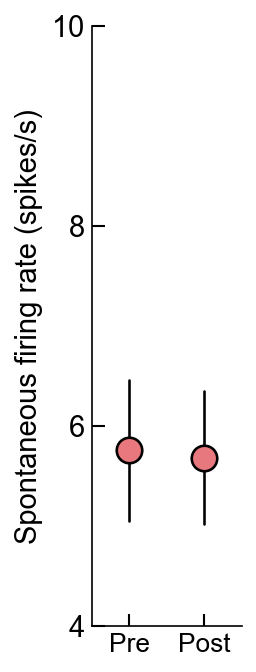

In [19]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_bl,switch_post_FR_bl]
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,1])):    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post']

# ax.set_ylim([0,8])
ax.set_ylim([4,10])
# ax.set_yticks([0,2,4,6,8])
ax.set_yticks([4,6,8,10])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,1.75+switch_offset])
ax.set_xticks([0-switch_offset,1+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch baseline summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [23]:
mannwhitneyu(ilep.rmnan(switch_pre_FR_bl),ilep.rmnan(switch_post_FR_bl))

MannwhitneyuResult(statistic=9721.5, pvalue=0.48803873769840445)

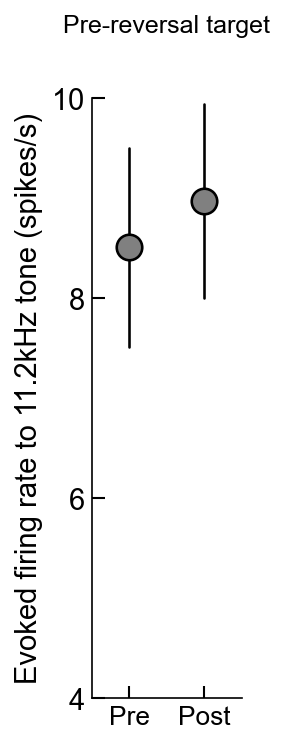

In [24]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_11k,switch_post_FR_11k]
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,1])):    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post']


# ax.set_ylim([0,8])
ax.set_ylim([4,10])
# ax.set_yticks([0,2,4,6,8])
ax.set_yticks([4,6,8,10])
ylab = ax.set_ylabel('Evoked firing rate to 11.2kHz tone (spikes/s)')

ax.set_xlim([-0.75-switch_offset,1.75+switch_offset])
ax.set_xticks([0-switch_offset,1+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ttl = ax.set_title('Pre-reversal target\n\n')

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,ttl]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch 11kHz evoked summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [25]:
mannwhitneyu(ilep.rmnan(switch_pre_FR_11k),ilep.rmnan(switch_post_FR_11k))

MannwhitneyuResult(statistic=9846.5, pvalue=0.606888326409343)

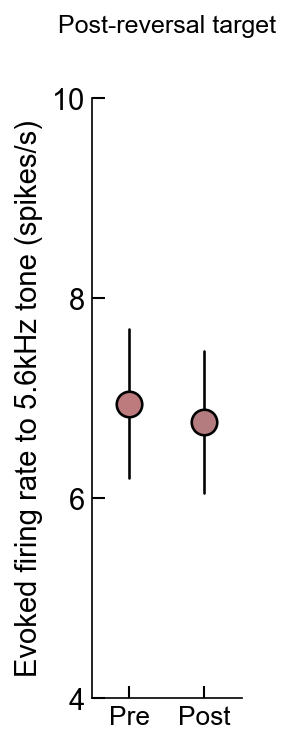

In [26]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_5k,switch_post_FR_5k]
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,1])):    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post']


# ax.set_ylim([0,8])
ax.set_ylim([4,10])
# ax.set_yticks([0,2,4,6,8])
ax.set_yticks([4,6,8,10])
ylab = ax.set_ylabel('Evoked firing rate to 5.6kHz tone (spikes/s)')

ax.set_xlim([-0.75-switch_offset,1.75+switch_offset])
ax.set_xticks([0-switch_offset,1+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ttl = ax.set_title('Post-reversal target\n\n')

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,ttl]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch 5kHz evoked summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [27]:
mannwhitneyu(ilep.rmnan(switch_pre_FR_5k),ilep.rmnan(switch_post_FR_5k))

MannwhitneyuResult(statistic=10116.0, pvalue=0.8975074195226365)

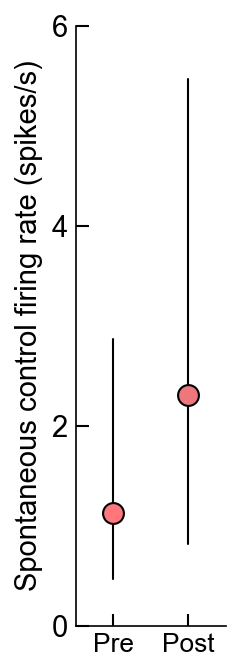

In [591]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [non_switch_pre_FR_bl,non_switch_post_FR_bl]
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,1])):    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post']

ax.set_ylim([0,6])
ax.set_yticks([0,2,4,6])
ylab = ax.set_ylabel('Spontaneous control firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,1.75+switch_offset])
ax.set_xticks([0-switch_offset,1+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC control baseline summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [573]:
mannwhitneyu(ilep.rmnan(non_switch_pre_FR_bl),ilep.rmnan(non_switch_post_FR_bl))

MannwhitneyuResult(statistic=72.0, pvalue=0.24133124222644808)

[147, 137, 53, 0]


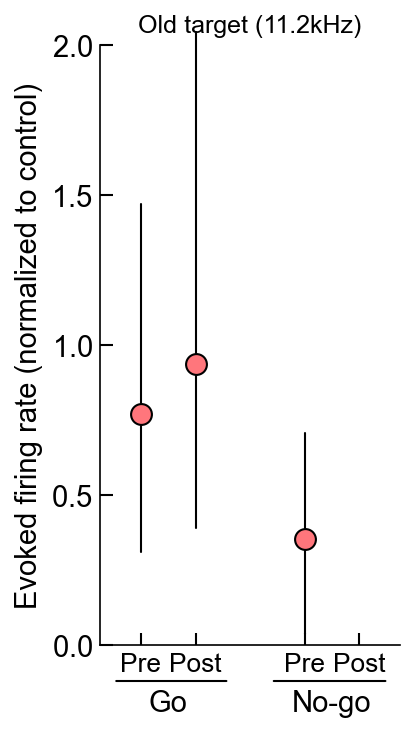

In [565]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_hit_norm,switch_post_FR_falarm_norm,switch_pre_FR_miss_norm,[]]#switch_post_FR_creject_norm]
print([np.sum(np.isfinite(l)) for l in data])
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,2])
ax.set_yticks([0,0.5,1,1.5,2])
ylab = ax.set_ylabel('Evoked firing rate (normalized to control)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('Old target (11.2kHz)')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation relative 11.2 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [550]:
mannwhitneyu(ilep.rmnan(switch_pre_FR_hit_norm),ilep.rmnan(switch_post_FR_falarm_norm))

MannwhitneyuResult(statistic=9113.0, pvalue=0.16685944411830778)

In [551]:
mannwhitneyu(ilep.rmnan(switch_pre_FR_miss_norm),ilep.rmnan(switch_post_FR_creject_norm))

ValueError: `x` and `y` must be of nonzero size.

[13, 14, 1, 0]


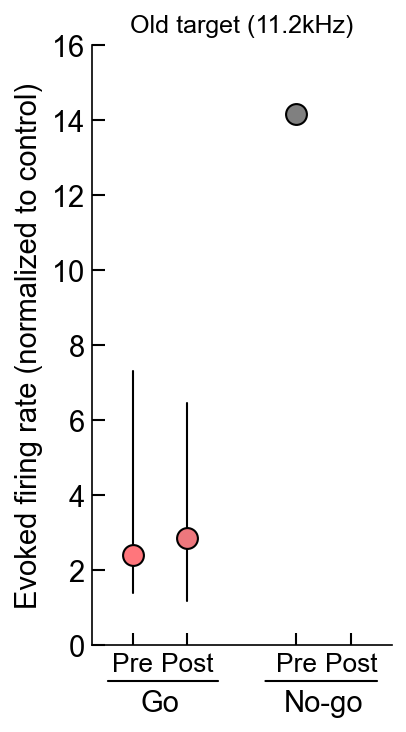

In [585]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [non_switch_pre_FR_hit,non_switch_post_FR_hit,non_switch_pre_FR_miss,[]]#switch_post_FR_creject_norm]
print([np.sum(np.isfinite(l)) for l in data])
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,16])
ax.set_yticks([0,2,4,6,8,10,12,14,16])
ylab = ax.set_ylabel('Evoked firing rate (normalized to control)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('Old target (11.2kHz)')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC control modulation 11.2 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [590]:
mannwhitneyu(ilep.rmnan(non_switch_pre_FR_hit),ilep.rmnan(non_switch_post_FR_hit))

MannwhitneyuResult(statistic=90.0, pvalue=0.9806368525541752)

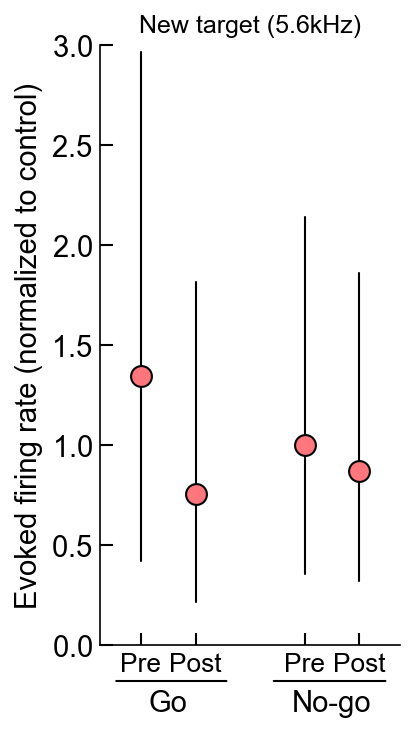

In [564]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_falarm_norm,switch_post_FR_hit_norm,switch_pre_FR_creject_norm,switch_post_FR_miss_norm]
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,3])
# ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (normalized to control)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('New target (5.6kHz)')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation relative 5.6 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [558]:
mannwhitneyu(ilep.rmnan(switch_pre_FR_falarm_norm),ilep.rmnan(switch_post_FR_hit_norm))

MannwhitneyuResult(statistic=12025.0, pvalue=0.009237556753482487)

In [559]:
mannwhitneyu(ilep.rmnan(switch_pre_FR_creject_norm),ilep.rmnan(switch_post_FR_miss_norm))

MannwhitneyuResult(statistic=10865.5, pvalue=0.2956041347582282)

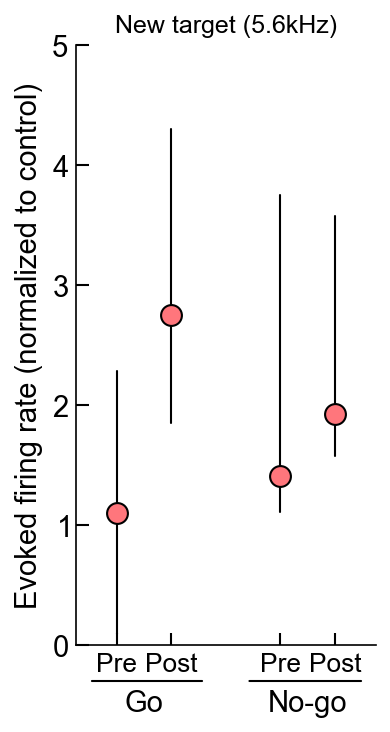

In [587]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [non_switch_pre_FR_falarm,non_switch_post_FR_falarm,non_switch_pre_FR_creject,non_switch_post_FR_creject]
numCon = len(data)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round',clip_on=False)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,5])
# ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (normalized to control)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('New target (5.6kHz)')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC control modulation 5.6 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [588]:
mannwhitneyu(ilep.rmnan(non_switch_pre_FR_falarm),ilep.rmnan(non_switch_post_FR_falarm))

MannwhitneyuResult(statistic=55.0, pvalue=0.05021327550357627)

In [589]:
mannwhitneyu(ilep.rmnan(non_switch_pre_FR_creject),ilep.rmnan(non_switch_post_FR_creject))

MannwhitneyuResult(statistic=75.5, pvalue=0.46558799063092493)

In [479]:
non_switch_pre_FR_miss

array([        nan,         nan,         nan,         nan,  0.        ,
        1.66666667,  1.66666667,  6.66666667, 11.66666667,  5.        ,
        6.66666667,  1.66666667,  3.33333333,  6.66666667,  0.        ,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 14.16666667])

In [480]:
non_switch_post_FR_miss

array([        nan,         nan,         nan,         nan,  1.5       ,
        4.        ,  1.        ,  3.        , 10.5       ,  2.        ,
        7.        ,  0.5       ,  3.5       ,  9.5       ,  1.04166667,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan])

In [454]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_50_7_AC.pickle')
ilep.getAllConditions(sessionfile,None,trialsPerDayLoaded='NO_TRIM')['miss']

namespace(trials=array([332, 437, 453, 462, 465, 473, 477, 478, 481, 482, 483, 484, 485,
                        486, 488, 491, 503, 504, 507, 513, 514, 516, 520, 526, 528, 530,
                        531]),
          label='miss')

In [455]:
sessionfile.meta.day_of_training

9

In [457]:
list(animalBehaviors['BS_50'].sessions[9].outcomes)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 3,


In [407]:
for idx,(session) in tqdm(enumerate(np.unique(EnumSession))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animal = sessionfile.meta.animal
    day = sessionfile.meta.day_of_training
        
    if day != control_animal_days[animal]:
        continue
        
    print(session)
    print(ilep.generateDateString(sessionfile))
    
#108,50,72,87
    
#108 - good
#40 - Has drift - use 10 instead
#49 - Has lots of drift - use 11 instead
#50 - Minor drift if anything - use 6 instead???
#70 - Has drift - especially later in session - no other options
#72 - Drift early in recording. Probably handled by removing first 100 trials (200s of drift)
#87 - good
#15 - has drift spikes
#19 - has slow drift across session

3it [00:00, 23.80it/s]

BS_108_2_AC.pickle
BS_108_2_AC_3-23-2022
BS_40_12_AC.pickle
BS_40_12_AC_8-19-2021


60it [00:00, 106.61it/s]

BS_49_12_AC.pickle
BS_49_12_AC_9-17-2021
BS_50_7_AC.pickle
BS_50_7_AC_9-20-2021
BS_70_1_AC.pickle
BS_70_1_AC_11-19-2021


92it [00:00, 132.40it/s]

BS_72_2_AC.pickle
BS_72_2_AC_11-24-2021
BS_87_2_AC.pickle
BS_87_2_AC_1-27-2022


120it [00:01, 106.61it/s]

DS_15_1_AC.pickle
DS_15_1_AC_4-8-2021
DS_19_1_AC.pickle
DS_19_1_AC_4-22-2021


132it [00:01, 93.10it/s] 


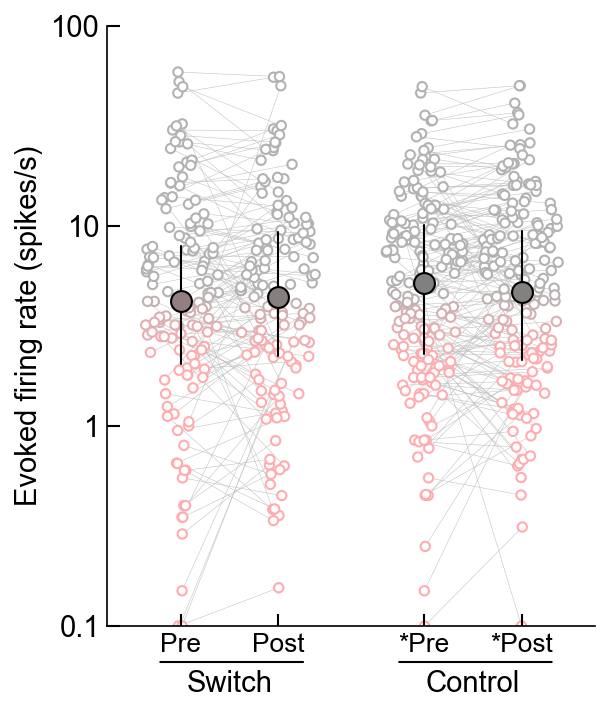

In [124]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR,switch_post_FR,non_switch_pre_FR,non_switch_post_FR]
labels = ['Early','Late','Expert','Early']
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(switch_pre_FR,switch_post_FR)
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(non_switch_pre_FR,non_switch_post_FR)
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

ax.scatter(X1, Y1, s=size, ec=colors1, fc='white', lw=1,zorder=-10)
ax.scatter(X2, Y2, s=size, ec=colors2, fc='white', lw=1,zorder=-10)
ax.plot([X1,X2],[Y1,Y2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.scatter(nX1, nY1, s=size, ec=ncolors1, fc='white', lw=1,zorder=-10)
ax.scatter(nX2, nY2, s=size, ec=ncolors2, fc='white', lw=1,zorder=-10)
ax.plot([nX1,nX2],[nY1,nY2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','*Pre','*Post']

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.92, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

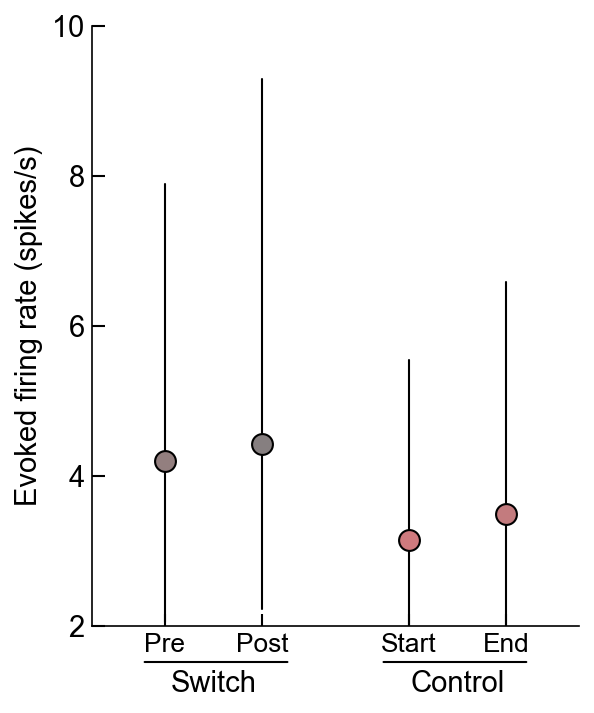

In [322]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR,switch_post_FR,non_switch_pre_FR,non_switch_post_FR]
labels = ['Early','Late','Expert','Early']
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(switch_pre_FR,switch_post_FR)
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(non_switch_pre_FR,non_switch_post_FR)
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End']

ax.set_ylim([2,10])
ax.set_yticks([2,4,6,8,10])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [323]:
X,Y = ilep.paired_rmnan(switch_pre_FR,switch_post_FR)
print(wilcoxon(X,Y))
print(mannwhitneyu(X,Y))

WilcoxonResult(statistic=4331.0, pvalue=0.6706297046059819)
MannwhitneyuResult(statistic=8961.5, pvalue=0.9798801105491081)


In [324]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR,non_switch_post_FR)
print(wilcoxon(X,Y))
print(mannwhitneyu(X,Y))

WilcoxonResult(statistic=53.0, pvalue=0.05316925048828125)
MannwhitneyuResult(statistic=163.0, pvalue=0.3234363510452939)


In [325]:
X = ilep.rmnan(switch_post_FR-switch_pre_FR)
Y = ilep.rmnan(non_switch_post_FR-non_switch_pre_FR)
mannwhitneyu(X,Y)

MannwhitneyuResult(statistic=1123.0, pvalue=0.24457358837803755)

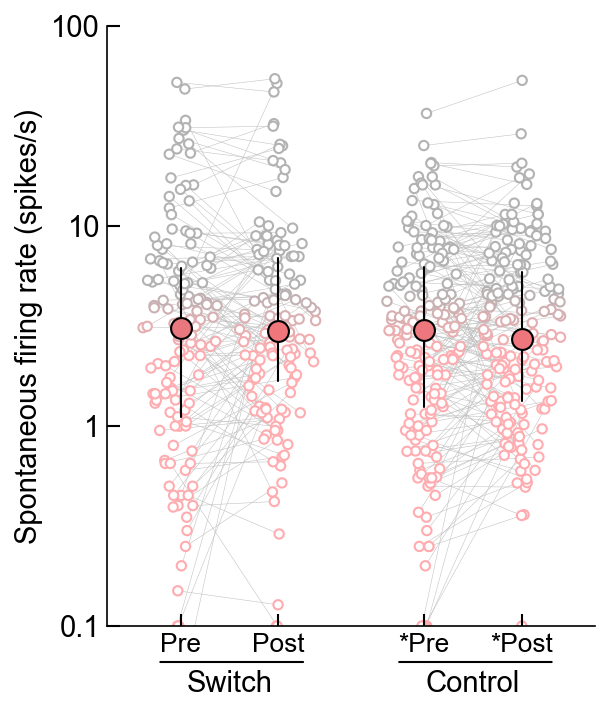

In [129]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_bl,switch_post_FR_bl,non_switch_pre_FR_bl,non_switch_post_FR_bl]
labels = ['Early','Late','Expert','Early']
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(switch_pre_FR_bl,switch_post_FR_bl)
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(non_switch_pre_FR_bl,non_switch_post_FR_bl)
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

ax.scatter(X1, Y1, s=size, ec=colors1, fc='white', lw=1,zorder=-10)
ax.scatter(X2, Y2, s=size, ec=colors2, fc='white', lw=1,zorder=-10)
ax.plot([X1,X2],[Y1,Y2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.scatter(nX1, nY1, s=size, ec=ncolors1, fc='white', lw=1,zorder=-10)
ax.scatter(nX2, nY2, s=size, ec=ncolors2, fc='white', lw=1,zorder=-10)
ax.plot([nX1,nX2],[nY1,nY2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','*Pre','*Post']

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.92, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC baseline switch vs control V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

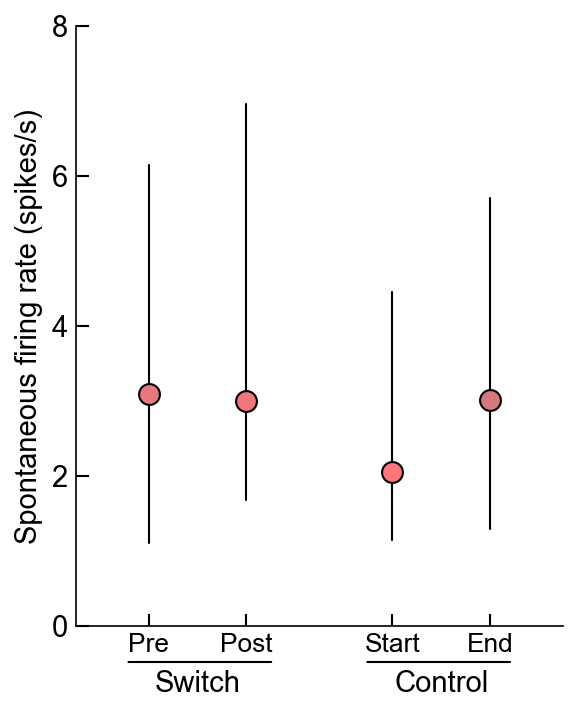

In [326]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_bl,switch_post_FR_bl,non_switch_pre_FR_bl,non_switch_post_FR_bl]
labels = ['Early','Late','Expert','Early']
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(switch_pre_FR,switch_post_FR)
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(non_switch_pre_FR,non_switch_post_FR)
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End']

ax.set_ylim([0,8])
ax.set_yticks([0,2,4,6,8])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control baseline summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

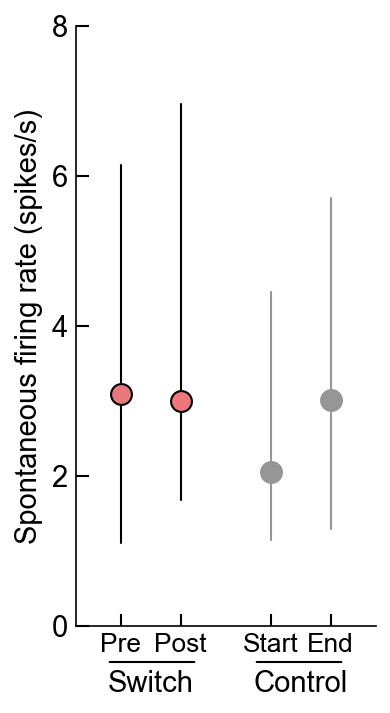

In [404]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_bl,switch_post_FR_bl,non_switch_pre_FR_bl,non_switch_post_FR_bl]
labels = ['Early','Late','Expert','Early']
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(switch_pre_FR,switch_post_FR)
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(non_switch_pre_FR,non_switch_post_FR)
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)

    if idx in [2,3]:
        eye_color = GOOD_GREY
        border_color = GOOD_GREY
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End']

ax.set_ylim([0,8])
ax.set_yticks([0,2,4,6,8])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control baseline summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

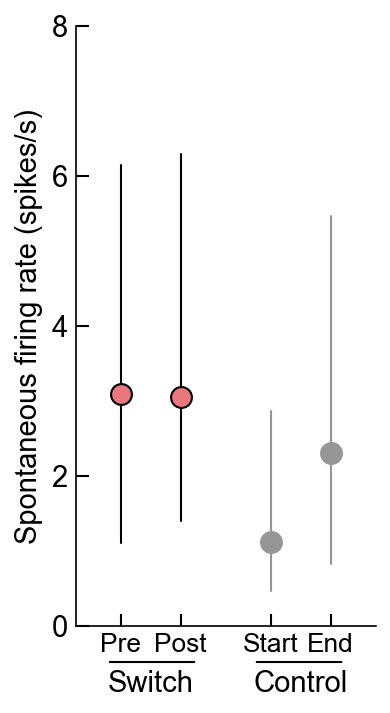

In [514]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_bl,switch_post_FR_bl,non_switch_pre_FR_bl,non_switch_post_FR_bl]
labels = ['Early','Late','Expert','Early']
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(switch_pre_FR,switch_post_FR)
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(non_switch_pre_FR,non_switch_post_FR)
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)

    if idx in [2,3]:
        eye_color = GOOD_GREY
        border_color = GOOD_GREY
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End']

ax.set_ylim([0,8])
ax.set_yticks([0,2,4,6,8])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Control', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control baseline summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [515]:
X,Y = ilep.paired_rmnan(switch_pre_FR_bl,switch_post_FR_bl)
print(wilcoxon(X,Y))
print(mannwhitneyu(X,Y))

WilcoxonResult(statistic=4133.5, pvalue=0.46958303753820396)
MannwhitneyuResult(statistic=8880.0, pvalue=0.8778585624599666)


In [516]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_bl,non_switch_post_FR_bl)
print(wilcoxon(X,Y))
print(mannwhitneyu(X,Y))

WilcoxonResult(statistic=13.0, pvalue=0.0830078125)
MannwhitneyuResult(statistic=44.0, pvalue=0.2934238832742103)


In [517]:
X = ilep.rmnan(switch_post_FR_bl-switch_pre_FR_bl)
Y = ilep.rmnan(non_switch_post_FR_bl-non_switch_pre_FR_bl)
mannwhitneyu(X,Y)

MannwhitneyuResult(statistic=452.0, pvalue=0.03362906934610154)

In [95]:
len(non_switch_pre_FR)

39

In [96]:
len(non_switch_post_FR)

39

In [97]:
len(non_switch_pre_FR_bl)

39

In [98]:
len(non_switch_post_FR_bl)

39

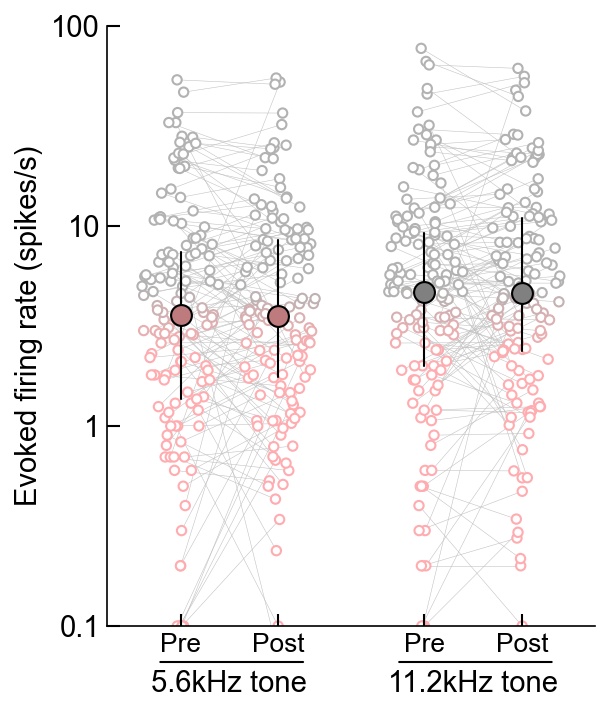

In [134]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_5k,switch_post_FR_5k,switch_pre_FR_11k,switch_post_FR_11k]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

ax.scatter(X1, Y1, s=size, ec=colors1, fc='white', lw=1,zorder=-10)
ax.scatter(X2, Y2, s=size, ec=colors2, fc='white', lw=1,zorder=-10)
ax.plot([X1,X2],[Y1,Y2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.scatter(nX1, nY1, s=size, ec=ncolors1, fc='white', lw=1,zorder=-10)
ax.scatter(nX2, nY2, s=size, ec=ncolors2, fc='white', lw=1,zorder=-10)
ax.plot([nX1,nX2],[nY1,nY2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, '5.6kHz tone', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, '11.2kHz tone', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.92, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC 5k vs 11k '+subset+' V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
fig.savefig(os.path.join('D:\\AC 5k vs 11k '+subset+' V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

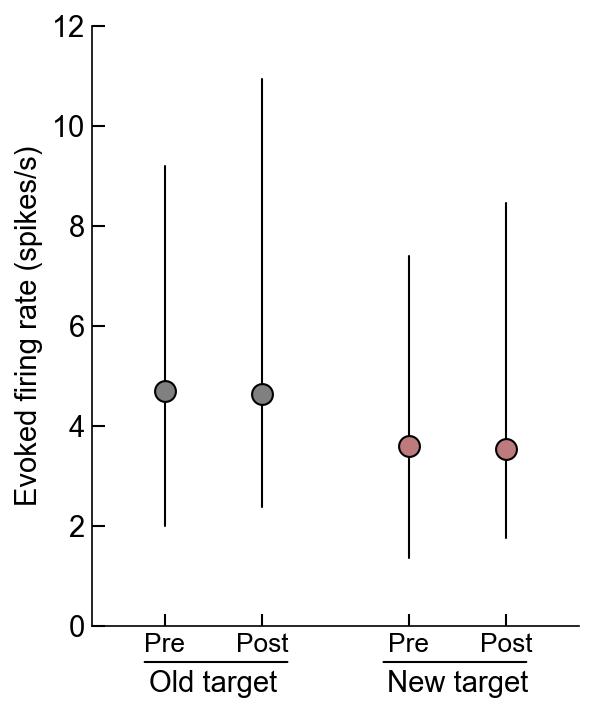

In [330]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_11k,switch_post_FR_11k,switch_pre_FR_5k,switch_post_FR_5k]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Old target', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'New target', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC 5k vs 11k '+subset+' summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [331]:
X,Y = ilep.paired_rmnan(switch_pre_FR_11k,switch_post_FR_11k)
wilcoxon(X,Y)

WilcoxonResult(statistic=3973.0, pvalue=0.27854193769436464)

In [332]:
X,Y = ilep.paired_rmnan(switch_pre_FR_5k,switch_post_FR_5k)
wilcoxon(X,Y)

WilcoxonResult(statistic=4268.0, pvalue=0.5719414267084358)

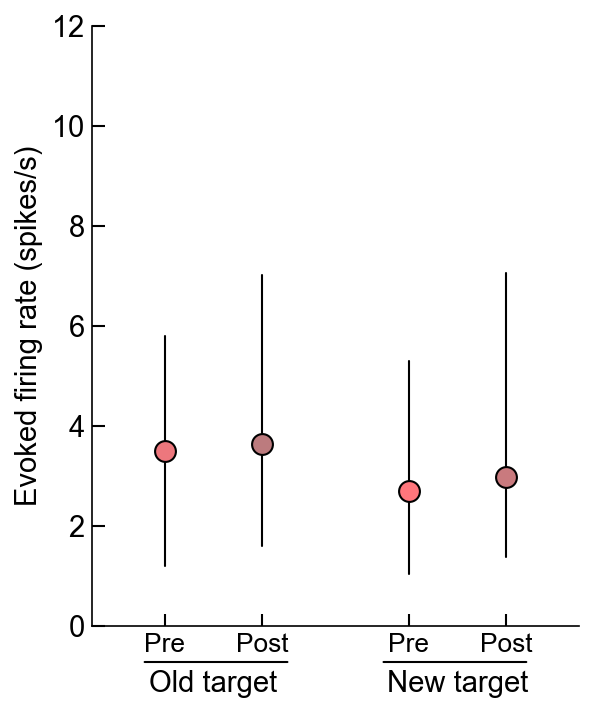

In [333]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [non_switch_pre_FR_11k,non_switch_post_FR_11k,non_switch_pre_FR_5k,non_switch_post_FR_5k]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Old target', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'New target', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC 5k vs 11k control '+subset+' summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [334]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_11k,non_switch_post_FR_11k)
wilcoxon(X,Y)

WilcoxonResult(statistic=52.0, pvalue=0.04844093322753906)

In [335]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_5k,non_switch_post_FR_5k)
wilcoxon(X,Y)

WilcoxonResult(statistic=50.0, pvalue=0.039989471435546875)

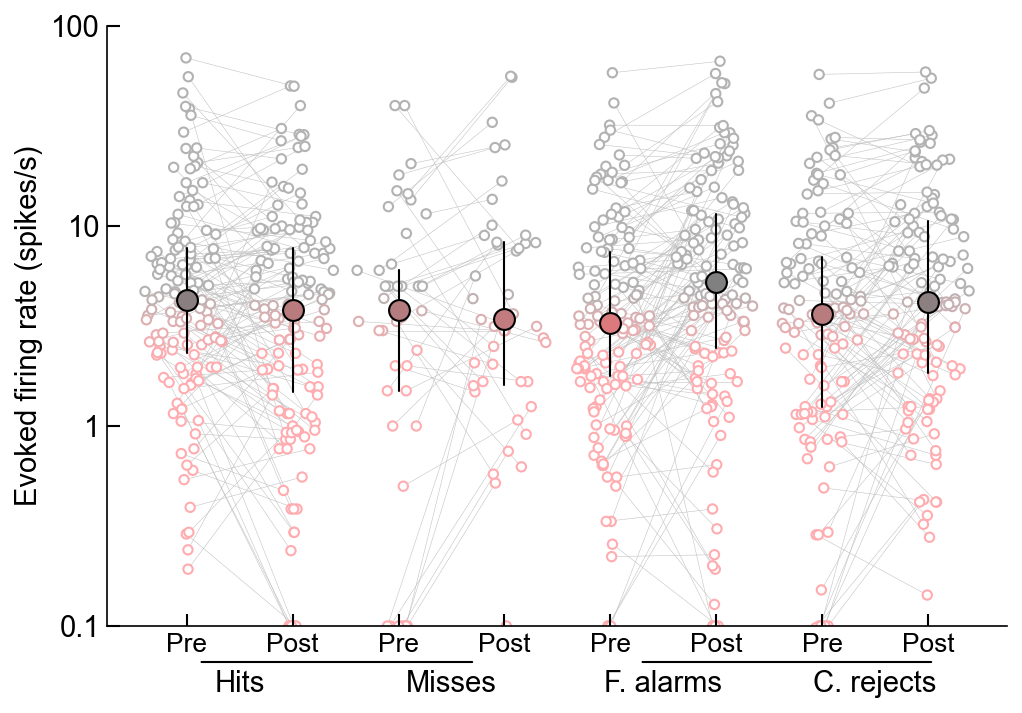

In [60]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(6, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_hit,switch_post_FR_hit,switch_pre_FR_miss,switch_post_FR_miss,switch_pre_FR_falarm,switch_post_FR_falarm,switch_pre_FR_creject,switch_post_FR_creject]
numCon = len(data)

###
aY1,aY2 = ilep.paired_rmnan(data[0],data[1])
aX1,aY1 = ilep.violin(aY1,log=True)
aX2,aY2 = ilep.violin(aY2,log=True)
aX1 = aX1+0-switch_offset
aX2 = aX2+1-switch_offset
acolors1 = NCR_CR_cmap( (aY1-(mn-spread/2))/ (spread) )
acolors2 = NCR_CR_cmap( (aY2-(mn-spread/2))/ (spread) )

bY1,bY2 = ilep.paired_rmnan(data[2],data[3])
bX1,bY1 = ilep.violin(bY1,log=True)
bX2,bY2 = ilep.violin(bY2,log=True)
bX1 = bX1+2-switch_offset
bX2 = bX2+3-switch_offset
bcolors1 = NCR_CR_cmap( (bY1-(mn-spread/2))/ (spread) )
bcolors2 = NCR_CR_cmap( (bY2-(mn-spread/2))/ (spread) )

cY1,cY2 = ilep.paired_rmnan(data[4],data[5])
cX1,cY1 = ilep.violin(cY1,log=True)
cX2,cY2 = ilep.violin(cY2,log=True)
cX1 = cX1+4-switch_offset
cX2 = cX2+5-switch_offset
ccolors1 = NCR_CR_cmap( (cY1-(mn-spread/2))/ (spread) )
ccolors2 = NCR_CR_cmap( (cY2-(mn-spread/2))/ (spread) )

dY1,dY2 = ilep.paired_rmnan(data[6],data[7])
dX1,dY1 = ilep.violin(dY1,log=True)
dX2,dY2 = ilep.violin(dY2,log=True)
dX1 = dX1+6-switch_offset
dX2 = dX2+7-switch_offset
dcolors1 = NCR_CR_cmap( (dY1-(mn-spread/2))/ (spread) )
dcolors2 = NCR_CR_cmap( (dY2-(mn-spread/2))/ (spread) )

ax.scatter(aX1, aY1, s=size, ec=acolors1, fc='white', lw=1,zorder=-10)
ax.scatter(aX2, aY2, s=size, ec=acolors2, fc='white', lw=1,zorder=-10)
ax.plot([aX1,aX2],[aY1,aY2],c=GOOD_GREY,lw=0.25,zorder=-11)

ax.scatter(bX1, bY1, s=size, ec=bcolors1, fc='white', lw=1,zorder=-10)
ax.scatter(bX2, bY2, s=size, ec=bcolors2, fc='white', lw=1,zorder=-10)
ax.plot([bX1,bX2],[bY1,bY2],c=GOOD_GREY,lw=0.25,zorder=-11)

ax.scatter(cX1, cY1, s=size, ec=ccolors1, fc='white', lw=1,zorder=-10)
ax.scatter(cX2, cY2, s=size, ec=ccolors2, fc='white', lw=1,zorder=-10)
ax.plot([cX1,cX2],[cY1,cY2],c=GOOD_GREY,lw=0.25,zorder=-11)

ax.scatter(dX1, dY1, s=size, ec=dcolors1, fc='white', lw=1,zorder=-10)
ax.scatter(dX2, dY2, s=size, ec=dcolors2, fc='white', lw=1,zorder=-10)
ax.plot([dX1,dX2],[dY1,dY2],c=GOOD_GREY,lw=0.25,zorder=-11)

ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,-1,1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post','Pre','Post','Pre','Post']

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,7.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset,4-switch_offset,5-switch_offset,6+switch_offset,7+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_1 = 0.5
xtick_pos_2 = 2.5
xtick_pos_3 = 4.5
xtick_pos_4 = 6.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_1-switch_offset, Yval, 'Hits', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_2-switch_offset, Yval, 'Misses', ha='center', va='bottom',  fontsize=stdfont,color='k')
t3 = ax.text(xtick_pos_3+switch_offset, Yval, 'F. alarms', ha='center', va='bottom', fontsize=stdfont,color='k')
t4 = ax.text(xtick_pos_4+switch_offset, Yval, 'C. rejects', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.92, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2,t3,t4]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch modulation all trial outcomes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
# fig.savefig(os.path.join('D:\\AC switch modulation all trial outcomes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [55]:
X,Y = ilep.paired_rmnan(switch_pre_FR_hit,switch_post_FR_hit)
wilcoxon(X,Y)

WilcoxonResult(statistic=3995.0, pvalue=0.3708496333221303)

In [56]:
X,Y = ilep.paired_rmnan(switch_pre_FR_miss,switch_post_FR_miss)
wilcoxon(X,Y)

WilcoxonResult(statistic=300.5, pvalue=0.0920581095518908)

In [57]:
X,Y = ilep.paired_rmnan(switch_pre_FR_falarm,switch_post_FR_falarm)
wilcoxon(X,Y)

WilcoxonResult(statistic=2313.0, pvalue=1.4970117891019884e-06)

In [58]:
X,Y = ilep.paired_rmnan(switch_pre_FR_creject,switch_post_FR_creject)
wilcoxon(X,Y)

WilcoxonResult(statistic=2679.0, pvalue=0.01813913488449757)

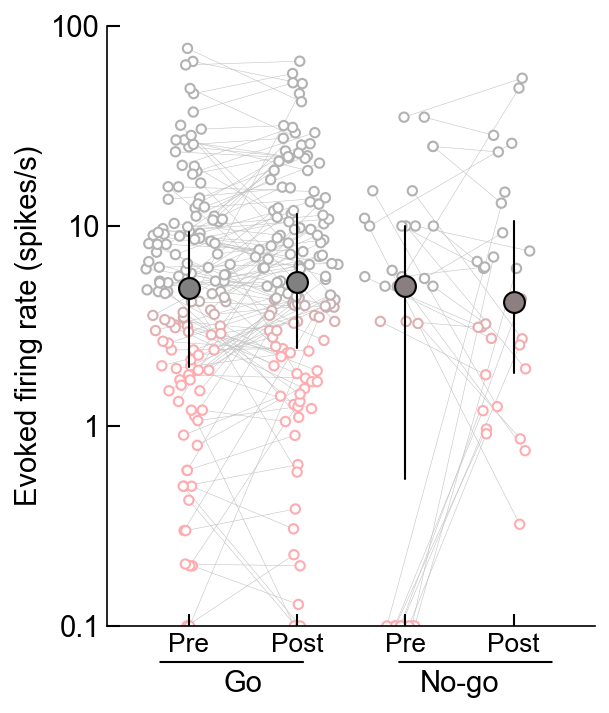

In [138]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_hit,switch_post_FR_falarm,switch_pre_FR_miss,switch_post_FR_creject]
numCon = len(data)

###
aY1,aY2 = ilep.paired_rmnan(data[0],data[1])
aX1,aY1 = ilep.violin(aY1,log=True)
aX2,aY2 = ilep.violin(aY2,log=True)
aX1 = aX1+0-switch_offset
aX2 = aX2+1-switch_offset
acolors1 = NCR_CR_cmap( (aY1-(mn-spread/2))/ (spread) )
acolors2 = NCR_CR_cmap( (aY2-(mn-spread/2))/ (spread) )

bY1,bY2 = ilep.paired_rmnan(data[2],data[3])
bX1,bY1 = ilep.violin(bY1,log=True)
bX2,bY2 = ilep.violin(bY2,log=True)
bX1 = bX1+2-switch_offset
bX2 = bX2+3-switch_offset
bcolors1 = NCR_CR_cmap( (bY1-(mn-spread/2))/ (spread) )
bcolors2 = NCR_CR_cmap( (bY2-(mn-spread/2))/ (spread) )

ax.scatter(aX1, aY1, s=size, ec=acolors1, fc='white', lw=1,zorder=-10)
ax.scatter(aX2, aY2, s=size, ec=acolors2, fc='white', lw=1,zorder=-10)
ax.plot([aX1,aX2],[aY1,aY2],c=GOOD_GREY,lw=0.25,zorder=-11)

ax.scatter(bX1, bY1, s=size, ec=bcolors1, fc='white', lw=1,zorder=-10)
ax.scatter(bX2, bY2, s=size, ec=bcolors2, fc='white', lw=1,zorder=-10)
ax.plot([bX1,bX2],[bY1,bY2],c=GOOD_GREY,lw=0.25,zorder=-11)

ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,-1,1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_1 = 0.5
xtick_pos_2 = 2.5
xtick_pos_3 = 4.5
xtick_pos_4 = 6.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_1-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_2-switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.92, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch modulation 11.2 trial outcomes go nogo V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
# fig.savefig(os.path.join('D:\\AC switch modulation all trial outcomes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

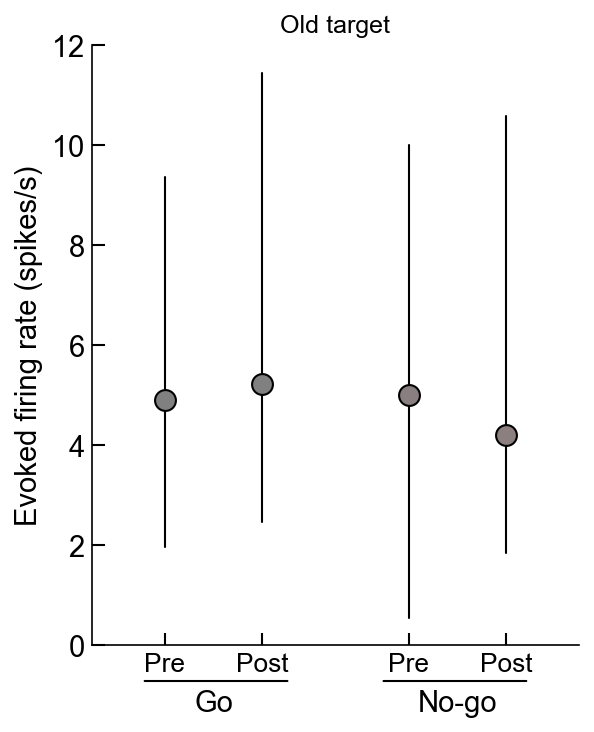

In [336]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_hit,switch_post_FR_falarm,switch_pre_FR_miss,switch_post_FR_creject]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('Old target')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch modulation 11.2 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [337]:
X,Y = ilep.paired_rmnan(switch_pre_FR_hit,switch_post_FR_falarm)
wilcoxon(X,Y)

WilcoxonResult(statistic=3433.0, pvalue=0.02990549694410555)

In [338]:
X,Y = ilep.paired_rmnan(switch_pre_FR_miss,switch_post_FR_creject)
wilcoxon(X,Y)

WilcoxonResult(statistic=212.0, pvalue=0.6732798065233047)

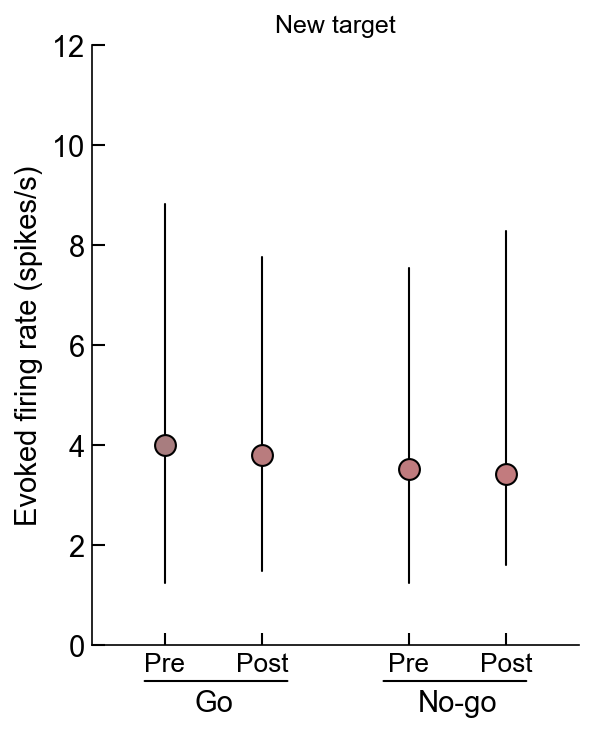

In [339]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_falarm,switch_post_FR_hit,switch_pre_FR_creject,switch_post_FR_miss]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('New target')

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch modulation 5.6 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [340]:
X,Y = ilep.paired_rmnan(switch_pre_FR_falarm,switch_post_FR_hit)
wilcoxon(X,Y)

WilcoxonResult(statistic=3844.5, pvalue=0.21619426831784705)

In [341]:
X,Y = ilep.paired_rmnan(switch_pre_FR_creject,switch_post_FR_miss)
wilcoxon(X,Y)

WilcoxonResult(statistic=4326.0, pvalue=0.6625552785788812)

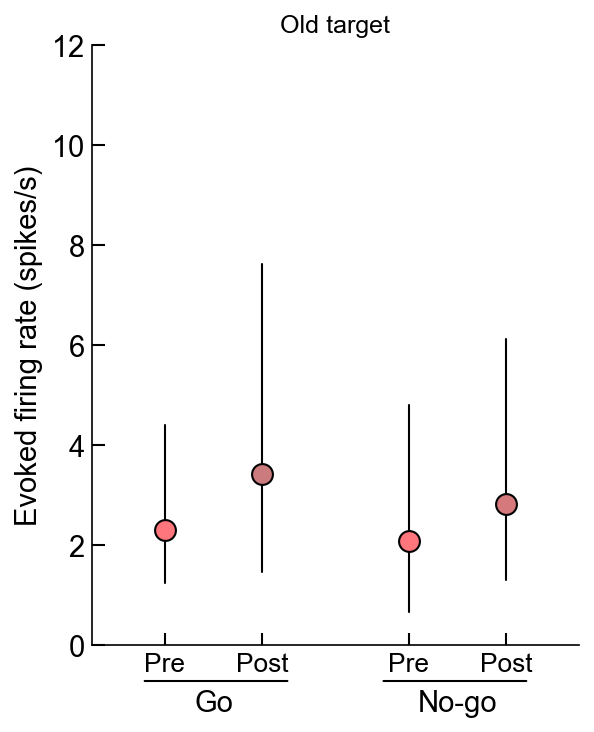

In [342]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [non_switch_pre_FR_falarm,non_switch_post_FR_falarm,non_switch_pre_FR_creject,non_switch_post_FR_creject]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('Old target')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation 11.2 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [343]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_falarm,non_switch_post_FR_falarm)
wilcoxon(X,Y)

WilcoxonResult(statistic=39.0, pvalue=0.012079238891601562)

In [344]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_creject,non_switch_post_FR_creject)
wilcoxon(X,Y)

WilcoxonResult(statistic=42.0, pvalue=0.5416259765625)

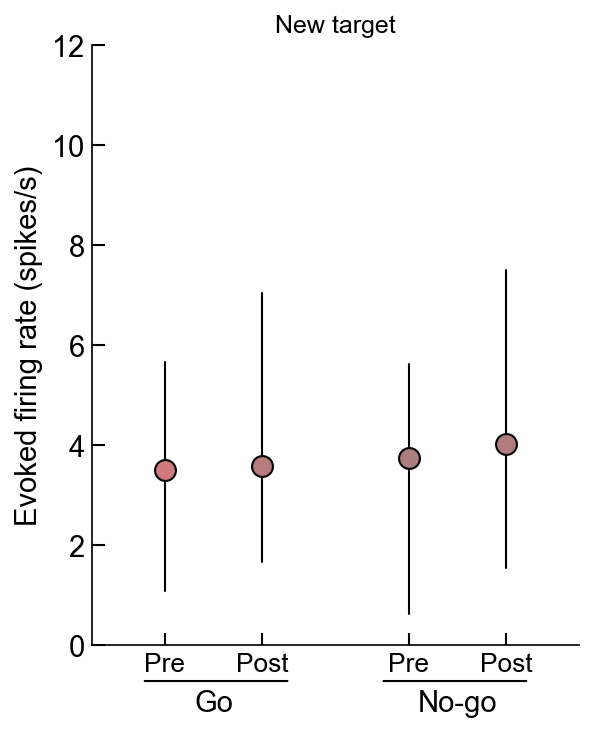

In [345]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [non_switch_pre_FR_hit,non_switch_post_FR_hit,non_switch_pre_FR_miss,non_switch_post_FR_miss]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.90, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('New target')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation 5.6 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [346]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_hit,non_switch_post_FR_hit)
wilcoxon(X,Y)

WilcoxonResult(statistic=55.0, pvalue=0.06372261047363281)

In [347]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_miss,non_switch_post_FR_miss)
wilcoxon(X,Y)

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=38.0, pvalue=0.9374729223624751)

In [417]:
[np.sum(np.isfinite(l)) for l in [non_switch_pre_FR_hit,non_switch_post_FR_hit,non_switch_pre_FR_miss,non_switch_post_FR_miss]]

[7, 20, 1, 0]

# Switch and Control co-presented

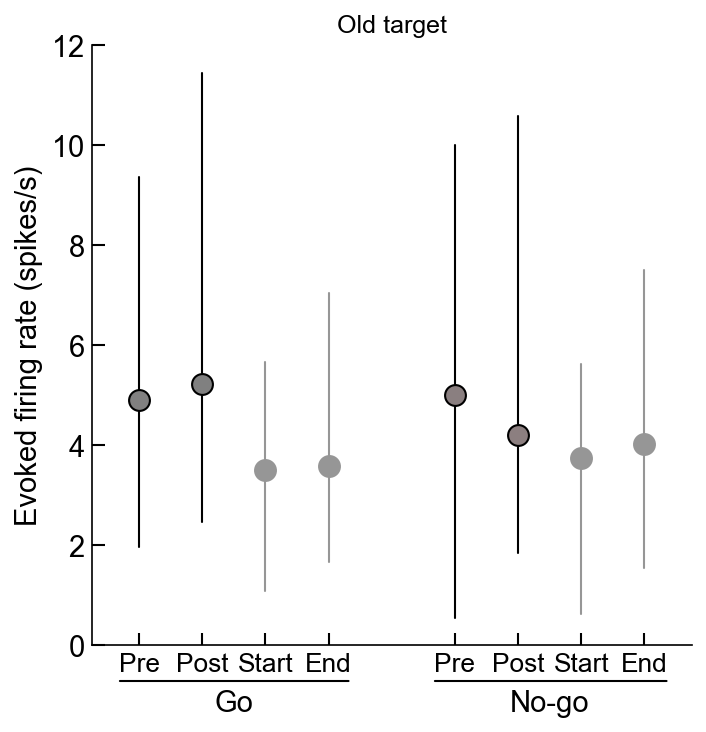

In [399]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_hit,switch_post_FR_falarm,switch_pre_FR_miss,switch_post_FR_creject]
data_control = [non_switch_pre_FR_hit,non_switch_post_FR_hit,non_switch_pre_FR_miss,non_switch_post_FR_miss]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

cY1,cY2 = ilep.paired_rmnan(data_control[0],data_control[1])
cX1,cY1 = ilep.violin(cY1,log=True)
cX2,cY2 = ilep.violin(cY2,log=True)
cX1 = cX1+2-switch_offset
cX2 = cX2+3-switch_offset
ccolors1 = NCR_CR_cmap( (cY1-(mn-spread/2))/ (spread) )
ccolors2 = NCR_CR_cmap( (cY2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+4+switch_offset
nX2 = nX2+5+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

cnY1,cnY2 = ilep.paired_rmnan(data_control[2],data_control[3])
cnX1,cnY1 = ilep.violin(cnY1,log=True)
cnX2,cnY2 = ilep.violin(cnY2,log=True)
cnX1 = cnX1+6+switch_offset
cnX2 = cnX2+7+switch_offset
cncolors1 = NCR_CR_cmap( (cnY1-(mn-spread/2))/ (spread) )
cncolors2 = NCR_CR_cmap( (cnY2-(mn-spread/2))/ (spread) )

#Plot summary
data_plot = [data[0], data[1], [], [], data[2], data[3], [], []]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot control summary
data_plot = [[], [], data_control[0], data_control[1], [], [], data_control[2], data_control[3]]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    border_color = GOOD_GREY
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End','Pre','Post','Start','End']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,7.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3-switch_offset,4+switch_offset,5+switch_offset,6+switch_offset,7+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 1.5
xtick_pos_post = 5.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('Old target')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation 11.2 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

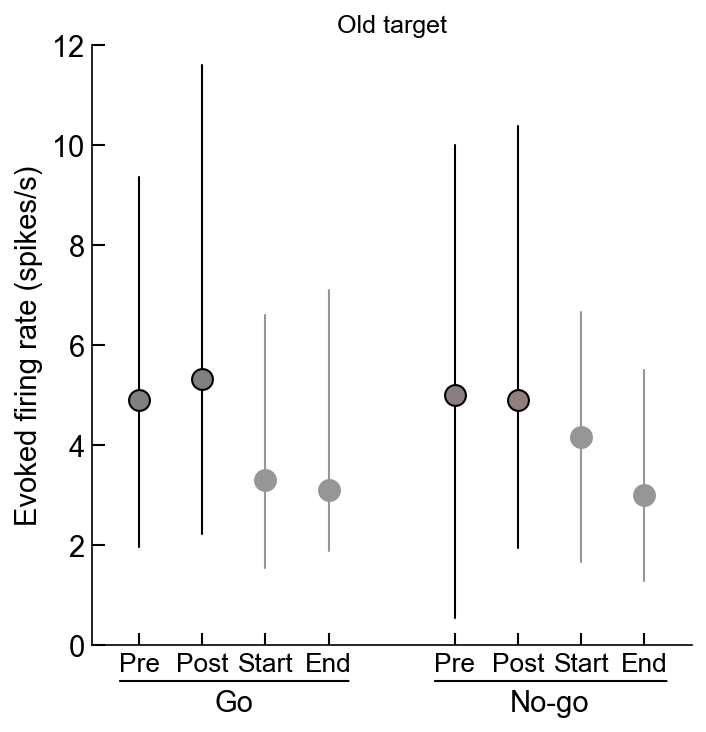

In [485]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_hit,switch_post_FR_falarm,switch_pre_FR_miss,switch_post_FR_creject]
data_control = [non_switch_pre_FR_hit,non_switch_post_FR_hit,non_switch_pre_FR_miss,non_switch_post_FR_miss]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

cY1,cY2 = ilep.paired_rmnan(data_control[0],data_control[1])
cX1,cY1 = ilep.violin(cY1,log=True)
cX2,cY2 = ilep.violin(cY2,log=True)
cX1 = cX1+2-switch_offset
cX2 = cX2+3-switch_offset
ccolors1 = NCR_CR_cmap( (cY1-(mn-spread/2))/ (spread) )
ccolors2 = NCR_CR_cmap( (cY2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+4+switch_offset
nX2 = nX2+5+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

cnY1,cnY2 = ilep.paired_rmnan(data_control[2],data_control[3])
cnX1,cnY1 = ilep.violin(cnY1,log=True)
cnX2,cnY2 = ilep.violin(cnY2,log=True)
cnX1 = cnX1+6+switch_offset
cnX2 = cnX2+7+switch_offset
cncolors1 = NCR_CR_cmap( (cnY1-(mn-spread/2))/ (spread) )
cncolors2 = NCR_CR_cmap( (cnY2-(mn-spread/2))/ (spread) )

#Plot summary
data_plot = [data[0], data[1], [], [], data[2], data[3], [], []]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot control summary
data_plot = [[], [], data_control[0], data_control[1], [], [], data_control[2], data_control[3]]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    border_color = GOOD_GREY
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End','Pre','Post','Start','End']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,7.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3-switch_offset,4+switch_offset,5+switch_offset,6+switch_offset,7+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 1.5
xtick_pos_post = 5.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('Old target')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation 11.2 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [486]:
X,Y = ilep.paired_rmnan(switch_pre_FR_hit,switch_post_FR_falarm)
wilcoxon(X,Y)

WilcoxonResult(statistic=3547.0, pvalue=0.09874207435553342)

In [487]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_hit,non_switch_post_FR_hit)
wilcoxon(X,Y)

WilcoxonResult(statistic=88.5, pvalue=0.015752519486415956)

In [488]:
X,Y = ilep.paired_rmnan(switch_pre_FR_miss,switch_post_FR_creject)
wilcoxon(X,Y)

WilcoxonResult(statistic=218.0, pvalue=0.7655072544526795)

In [489]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_miss,non_switch_post_FR_miss)
wilcoxon(X,Y)

WilcoxonResult(statistic=31.0, pvalue=0.8984375)

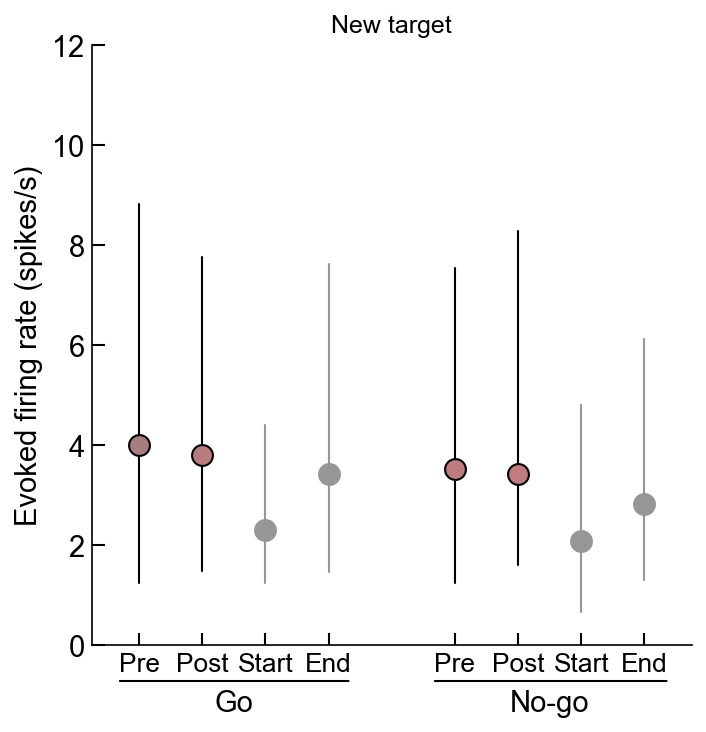

In [400]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_falarm,switch_post_FR_hit,switch_pre_FR_creject,switch_post_FR_miss]
data_control = [non_switch_pre_FR_falarm,non_switch_post_FR_falarm,non_switch_pre_FR_creject,non_switch_post_FR_creject]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

cY1,cY2 = ilep.paired_rmnan(data_control[0],data_control[1])
cX1,cY1 = ilep.violin(cY1,log=True)
cX2,cY2 = ilep.violin(cY2,log=True)
cX1 = cX1+2-switch_offset
cX2 = cX2+3-switch_offset
ccolors1 = NCR_CR_cmap( (cY1-(mn-spread/2))/ (spread) )
ccolors2 = NCR_CR_cmap( (cY2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+4+switch_offset
nX2 = nX2+5+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

cnY1,cnY2 = ilep.paired_rmnan(data_control[2],data_control[3])
cnX1,cnY1 = ilep.violin(cnY1,log=True)
cnX2,cnY2 = ilep.violin(cnY2,log=True)
cnX1 = cnX1+6+switch_offset
cnX2 = cnX2+7+switch_offset
cncolors1 = NCR_CR_cmap( (cnY1-(mn-spread/2))/ (spread) )
cncolors2 = NCR_CR_cmap( (cnY2-(mn-spread/2))/ (spread) )

#Plot summary
data_plot = [data[0], data[1], [], [], data[2], data[3], [], []]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot control summary
data_plot = [[], [], data_control[0], data_control[1], [], [], data_control[2], data_control[3]]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    border_color = GOOD_GREY
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End','Pre','Post','Start','End']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,7.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3-switch_offset,4+switch_offset,5+switch_offset,6+switch_offset,7+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 1.5
xtick_pos_post = 5.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('New target')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation 5.6 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

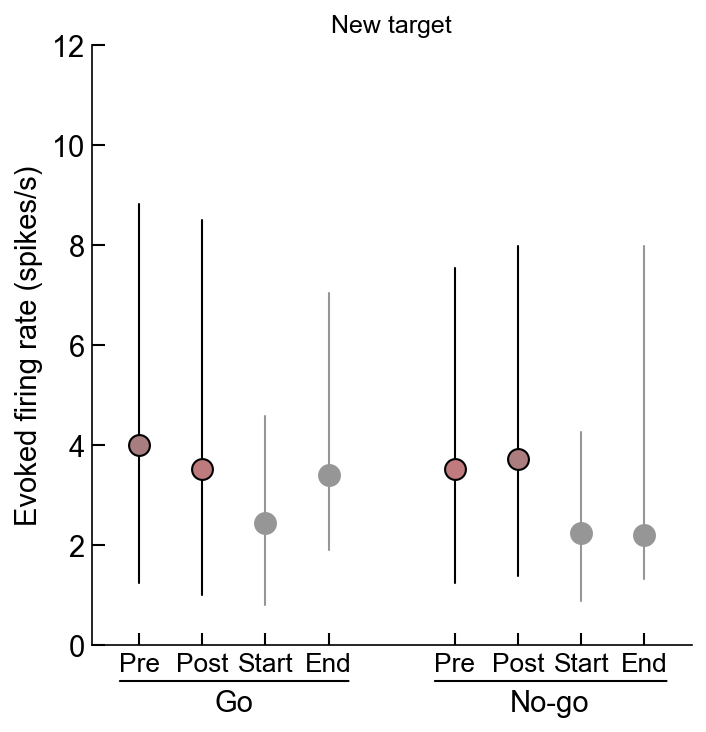

In [490]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.5

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [switch_pre_FR_falarm,switch_post_FR_hit,switch_pre_FR_creject,switch_post_FR_miss]
data_control = [non_switch_pre_FR_falarm,non_switch_post_FR_falarm,non_switch_pre_FR_creject,non_switch_post_FR_creject]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

cY1,cY2 = ilep.paired_rmnan(data_control[0],data_control[1])
cX1,cY1 = ilep.violin(cY1,log=True)
cX2,cY2 = ilep.violin(cY2,log=True)
cX1 = cX1+2-switch_offset
cX2 = cX2+3-switch_offset
ccolors1 = NCR_CR_cmap( (cY1-(mn-spread/2))/ (spread) )
ccolors2 = NCR_CR_cmap( (cY2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+4+switch_offset
nX2 = nX2+5+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

cnY1,cnY2 = ilep.paired_rmnan(data_control[2],data_control[3])
cnX1,cnY1 = ilep.violin(cnY1,log=True)
cnX2,cnY2 = ilep.violin(cnY2,log=True)
cnX1 = cnX1+6+switch_offset
cnX2 = cnX2+7+switch_offset
cncolors1 = NCR_CR_cmap( (cnY1-(mn-spread/2))/ (spread) )
cncolors2 = NCR_CR_cmap( (cnY2-(mn-spread/2))/ (spread) )

#Plot summary
data_plot = [data[0], data[1], [], [], data[2], data[3], [], []]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot control summary
data_plot = [[], [], data_control[0], data_control[1], [], [], data_control[2], data_control[3]]
for idx,(column,polarity) in enumerate(zip(data_plot,[-1,-1,-1,-1,1,1,1,1])):
    if len(column) == 0:
        continue
    
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    border_color = GOOD_GREY
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Start','End','Pre','Post','Start','End']

ax.set_ylim([0,12])
ax.set_yticks([0,2,4,6,8,10,12])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,7.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3-switch_offset,4+switch_offset,5+switch_offset,6+switch_offset,7+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 1.5
xtick_pos_post = 5.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.435, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.565, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.set_title('New target')
# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch control modulation 5.6 trial outcomes go nogo summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [491]:
X,Y = ilep.paired_rmnan(switch_pre_FR_falarm,switch_post_FR_hit)
wilcoxon(X,Y)

WilcoxonResult(statistic=3831.0, pvalue=0.39544610240684464)

In [492]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_falarm,non_switch_post_FR_falarm)
wilcoxon(X,Y)

WilcoxonResult(statistic=84.0, pvalue=0.006732391536583077)

In [493]:
X,Y = ilep.paired_rmnan(switch_pre_FR_creject,switch_post_FR_miss)
wilcoxon(X,Y)

WilcoxonResult(statistic=3743.5, pvalue=0.23232892815331851)

In [494]:
X,Y = ilep.paired_rmnan(non_switch_pre_FR_creject,non_switch_post_FR_creject)
wilcoxon(X,Y)

WilcoxonResult(statistic=47.0, pvalue=0.017270445346494193)

# Comparisons by animal -- predictive of learning

In [10]:
switch_FR_by_animal = dict()
for animal in animals:
    switch_FR_by_animal[animal] = SimpleNamespace()
    switch_FR_by_animal[animal].switch_pre_FR = []
    switch_FR_by_animal[animal].switch_post_FR = []
    switch_FR_by_animal[animal].switch_pre_FR_bl = []
    switch_FR_by_animal[animal].switch_post_FR_bl = []
    switch_FR_by_animal[animal].switch_pre_FR_5k = []
    switch_FR_by_animal[animal].switch_pre_FR_11k = []
    switch_FR_by_animal[animal].switch_post_FR_5k = []
    switch_FR_by_animal[animal].switch_post_FR_11k = []
    
for current_animal in animals:
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training

        if animal != current_animal:
            continue
        
        if EILphases[idx] not in ['switch']:
            continue

        allConditions = ilep.getAllConditions(sessionfile,clust)
        this_FR_pre = []
        this_FR_pre_bl = []
        for trial in allConditions['pre_switch'].trials:

            trialStart = sessionfile.trials.starts[trial]
            trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_pre.append(FR)

            ###############################################################################################

            trialStart = sessionfile.trials.starts[trial] - 0.2 * sessionfile.meta.fs
            trialEnd = sessionfile.trials.starts[trial]

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_pre_bl.append(FR)

        this_FR_post = []
        this_FR_post_bl = []
        for trial in allConditions['post_switch'].trials:

            trialStart = sessionfile.trials.starts[trial]
            trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_post.append(FR)

            ###############################################################################################

            trialStart = sessionfile.trials.starts[trial] - 0.2 * sessionfile.meta.fs
            trialEnd = sessionfile.trials.starts[trial]

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_post_bl.append(FR)

        ###################################################################################################
        ###################################################################################################
        ###################################################################################################

        this_FR_pre_5k = []
        for trial in allConditions['pre_switch_nontarget'].trials:

            trialStart = sessionfile.trials.starts[trial]
            trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_pre_5k.append(FR)

        this_FR_pre_11k = []
        for trial in allConditions['pre_switch_target'].trials:

            trialStart = sessionfile.trials.starts[trial]
            trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_pre_11k.append(FR)

        this_FR_post_5k = []
        for trial in allConditions['post_switch_target'].trials:

            trialStart = sessionfile.trials.starts[trial]
            trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_post_5k.append(FR)

        this_FR_post_11k = []
        for trial in allConditions['post_switch_nontarget'].trials:

            trialStart = sessionfile.trials.starts[trial]
            trialEnd = sessionfile.trials.starts[trial] + 0.2 * sessionfile.meta.fs

            spikeTimes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=trialStart,endtime=trialEnd)
            FR = len(spikeTimes) / 0.2
            this_FR_post_11k.append(FR)

        switch_FR_by_animal[current_animal].switch_pre_FR.append(np.mean(this_FR_pre))
        switch_FR_by_animal[current_animal].switch_post_FR.append(np.mean(this_FR_post))
        switch_FR_by_animal[current_animal].switch_pre_FR_bl.append(np.mean(this_FR_pre_bl))
        switch_FR_by_animal[current_animal].switch_post_FR_bl.append(np.mean(this_FR_post_bl))
        switch_FR_by_animal[current_animal].switch_pre_FR_5k.append(np.mean(this_FR_pre_5k))
        switch_FR_by_animal[current_animal].switch_pre_FR_11k.append(np.mean(this_FR_pre_11k))
        switch_FR_by_animal[current_animal].switch_post_FR_5k.append(np.mean(this_FR_post_5k))
        switch_FR_by_animal[current_animal].switch_post_FR_11k.append(np.mean(this_FR_post_11k))

    switch_FR_by_animal[current_animal].switch_pre_FR = np.array(switch_FR_by_animal[current_animal].switch_pre_FR)
    switch_FR_by_animal[current_animal].switch_post_FR = np.array(switch_FR_by_animal[current_animal].switch_post_FR)
    switch_FR_by_animal[current_animal].switch_pre_FR_bl = np.array(switch_FR_by_animal[current_animal].switch_pre_FR_bl)
    switch_FR_by_animal[current_animal].switch_post_FR_bl = np.array(switch_FR_by_animal[current_animal].switch_post_FR_bl)
    switch_FR_by_animal[current_animal].switch_pre_FR_5k = np.array(switch_FR_by_animal[current_animal].switch_pre_FR_5k)
    switch_FR_by_animal[current_animal].switch_pre_FR_11k = np.array(switch_FR_by_animal[current_animal].switch_pre_FR_11k)
    switch_FR_by_animal[current_animal].switch_pos_FR_5k = np.array(switch_FR_by_animal[current_animal].switch_post_FR_5k)
    switch_FR_by_animal[current_animal].switch_post_FR_11k = np.array(switch_FR_by_animal[current_animal].switch_post_FR_11k)

93it [00:02, 75.82it/s]

session BS_40_14_AC_8-23-2021 clust 12 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 12 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 12 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 12 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 12 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 12 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

102it [00:02, 33.73it/s]

session BS_40_14_AC_8-23-2021 clust 21 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 21 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 21 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 21 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 21 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 21 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

109it [00:05,  8.00it/s]

session BS_40_14_AC_8-23-2021 clust 53 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 53 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 53 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 53 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 53 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 53 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

114it [00:10,  3.66it/s]

session BS_40_14_AC_8-23-2021 clust 96 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 96 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 96 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 96 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 96 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 96 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

118it [00:12,  3.05it/s]

session BS_40_14_AC_8-23-2021 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file

121it [00:15,  2.24it/s]

session BS_40_14_AC_8-23-2021 clust 111 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 111 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 111 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 111 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 111 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 111 tried to load saved active trials but failed. Error: [Errno 2] No such file

123it [00:18,  1.68it/s]

session BS_40_14_AC_8-23-2021 clust 115 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 115 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 115 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 115 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 115 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_40_14_AC_8-23-2021 clust 115 tried to load saved active trials but failed. Error: [Errno 2] No such file

1830it [00:50, 36.32it/s] 
312it [00:07, 105.86it/s]

session BS_41_1_AC_8-5-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\User

324it [00:09, 17.92it/s] 

session BS_41_1_AC_8-5-2021 clust 58 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 58 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 58 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 58 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 58 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 58 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:

333it [00:12,  7.67it/s]

session BS_41_1_AC_8-5-2021 clust 173 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 173 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 173 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 173 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 173 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 173 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

339it [00:13,  6.33it/s]

session BS_41_1_AC_8-5-2021 clust 238 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 238 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 238 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 238 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 238 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 238 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

344it [00:14,  6.00it/s]

session BS_41_1_AC_8-5-2021 clust 318 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 318 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 318 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 318 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 318 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 318 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

348it [00:16,  4.80it/s]

session BS_41_1_AC_8-5-2021 clust 342 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 342 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 342 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 342 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 342 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 342 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

351it [00:17,  4.53it/s]

session BS_41_1_AC_8-5-2021 clust 354 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 354 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 354 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 354 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 354 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 354 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

353it [00:18,  3.65it/s]

session BS_41_1_AC_8-5-2021 clust 360 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 360 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 360 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 360 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 360 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 360 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

356it [00:20,  3.03it/s]

session BS_41_1_AC_8-5-2021 clust 363 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 363 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 363 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 363 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 363 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_41_1_AC_8-5-2021 clust 363 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

1830it [00:43, 41.60it/s] 
467it [00:11, 84.79it/s]

session BS_42_1_AC_8-6-2021 clust 1 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 1 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 1 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 1 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 1 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 1 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\User

476it [00:12, 30.59it/s]

session BS_42_1_AC_8-6-2021 clust 34 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 34 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 34 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 34 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 34 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 34 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:

483it [00:13, 21.97it/s]

session BS_42_1_AC_8-6-2021 clust 61 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 61 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 61 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 61 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 61 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 61 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:

492it [00:13, 21.43it/s]

session BS_42_1_AC_8-6-2021 clust 91 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 91 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 91 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_42_1_AC_8-6-2021 clust 91 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'


1830it [00:35, 51.93it/s] 
1830it [00:33, 54.19it/s] 
1830it [00:33, 54.27it/s] 
1830it [00:33, 54.44it/s] 
1830it [00:33, 54.61it/s] 
1830it [00:33, 54.43it/s] 
1830it [00:33, 54.47it/s] 
941it [00:19, 112.60it/s]

session BS_70_4_AC_11-24-2021 clust 15 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_70_4_AC_11-24-2021 clust 15 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_70_4_AC_11-24-2021 clust 15 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_70_4_AC_11-24-2021 clust 15 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_70_4_AC_11-24-2021 clust 15 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_70_4_AC_11-24-2021 clust 15 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

1830it [00:33, 54.02it/s] 
1048it [00:20, 125.64it/s]

session BS_72_3_AC_11-26-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_72_3_AC_11-26-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_72_3_AC_11-26-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_72_3_AC_11-26-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_72_3_AC_11-26-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_72_3_AC_11-26-2021 clust 0 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

1830it [00:37, 48.66it/s] 
1830it [00:33, 54.53it/s] 
11it [00:00, 38.72it/s]

session BS_108_3_AC_3-24-2022 clust 19 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 19 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 19 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 19 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 19 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 19 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

15it [00:01,  8.52it/s]

session BS_108_3_AC_3-24-2022 clust 81 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 81 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 81 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 81 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 81 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 81 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

17it [00:02,  6.05it/s]

session BS_108_3_AC_3-24-2022 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 107 tried to load saved active trials but failed. Error: [Errno 2] No such file

19it [00:02,  4.57it/s]

session BS_108_3_AC_3-24-2022 clust 144 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 144 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 144 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 144 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 144 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 144 tried to load saved active trials but failed. Error: [Errno 2] No such file

21it [00:03,  4.53it/s]

session BS_108_3_AC_3-24-2022 clust 155 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 155 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 155 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 155 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 155 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 155 tried to load saved active trials but failed. Error: [Errno 2] No such file

23it [00:04,  4.16it/s]

session BS_108_3_AC_3-24-2022 clust 175 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 175 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 175 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 175 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 175 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 175 tried to load saved active trials but failed. Error: [Errno 2] No such file

25it [00:04,  4.35it/s]

session BS_108_3_AC_3-24-2022 clust 186 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 186 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 186 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 186 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 186 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 186 tried to load saved active trials but failed. Error: [Errno 2] No such file

26it [00:04,  4.03it/s]

session BS_108_3_AC_3-24-2022 clust 195 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 195 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 195 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 195 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 195 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 195 tried to load saved active trials but failed. Error: [Errno 2] No such file

28it [00:05,  3.59it/s]

session BS_108_3_AC_3-24-2022 clust 215 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 215 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 215 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 215 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 215 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 215 tried to load saved active trials but failed. Error: [Errno 2] No such file

29it [00:05,  3.52it/s]

session BS_108_3_AC_3-24-2022 clust 229 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 229 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 229 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 229 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 229 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 229 tried to load saved active trials but failed. Error: [Errno 2] No such file

30it [00:06,  3.56it/s]

session BS_108_3_AC_3-24-2022 clust 242 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 242 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 242 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 242 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 242 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 242 tried to load saved active trials but failed. Error: [Errno 2] No such file

32it [00:06,  3.72it/s]

session BS_108_3_AC_3-24-2022 clust 254 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 254 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 254 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 254 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 254 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 254 tried to load saved active trials but failed. Error: [Errno 2] No such file

34it [00:07,  3.54it/s]

session BS_108_3_AC_3-24-2022 clust 272 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 272 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 272 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 272 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 272 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 272 tried to load saved active trials but failed. Error: [Errno 2] No such file

35it [00:07,  3.68it/s]

session BS_108_3_AC_3-24-2022 clust 316 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 316 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 316 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 316 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 316 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 316 tried to load saved active trials but failed. Error: [Errno 2] No such file

36it [00:07,  3.74it/s]

session BS_108_3_AC_3-24-2022 clust 340 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 340 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 340 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 340 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 340 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 340 tried to load saved active trials but failed. Error: [Errno 2] No such file

37it [00:07,  3.83it/s]

session BS_108_3_AC_3-24-2022 clust 348 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 348 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 348 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 348 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 348 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 348 tried to load saved active trials but failed. Error: [Errno 2] No such file

38it [00:08,  3.75it/s]

session BS_108_3_AC_3-24-2022 clust 361 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 361 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 361 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 361 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 361 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 361 tried to load saved active trials but failed. Error: [Errno 2] No such file

40it [00:08,  3.60it/s]

session BS_108_3_AC_3-24-2022 clust 362 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 362 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 362 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 362 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 362 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session BS_108_3_AC_3-24-2022 clust 362 tried to load saved active trials but failed. Error: [Errno 2] No such file

1830it [00:41, 44.53it/s] 
1470it [00:26, 101.07it/s]

session DS_15_2_AC_04-09-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

1481it [00:26, 40.88it/s] 

session DS_15_2_AC_04-09-2021 clust 57 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 57 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 57 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 57 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 57 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_15_2_AC_04-09-2021 clust 57 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

1830it [00:34, 53.51it/s] 
1620it [00:27, 122.83it/s]

session DS_19_2_AC_04-23-2021 clust 2 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 2 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 2 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 2 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 2 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 2 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

1633it [00:28, 51.58it/s] 

session DS_19_2_AC_04-23-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 4 tried to load saved active trials but failed. Error: [Errno 2] No such file or director

1643it [00:36,  4.59it/s]

session DS_19_2_AC_04-23-2021 clust 32 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 32 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 32 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 32 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 32 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 32 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

1650it [00:41,  3.39it/s]

session DS_19_2_AC_04-23-2021 clust 79 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 79 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 79 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 79 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 79 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 79 tried to load saved active trials but failed. Error: [Errno 2] No such file or di

1655it [00:43,  3.21it/s]

session DS_19_2_AC_04-23-2021 clust 102 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 102 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 102 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 102 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 102 tried to load saved active trials but failed. Error: [Errno 2] No such file or directory: 'C:\\Users\\insan\\Desktop\\trialsToUsePerDay'
session DS_19_2_AC_04-23-2021 clust 102 tried to load saved active trials but failed. Error: [Errno 2] No such file

1830it [00:48, 37.49it/s]


In [25]:
mean_pre_5k = []
mean_post_5k = []
sem_pre_5k = []
sem_post_5k = []
sig_5k = []

mean_pre_11k = []
mean_post_11k = []
sem_pre_11k = []
sem_post_11k = []
sig_11k = []

for animal in animals:
    mean_pre_5k.append(np.nanmean(switch_FR_by_animal[animal].switch_pre_FR_5k))
    mean_post_5k.append(np.nanmean(switch_FR_by_animal[animal].switch_post_FR_5k))
    mean_pre_11k.append(np.nanmean(switch_FR_by_animal[animal].switch_pre_FR_11k))
    mean_post_11k.append(np.nanmean(switch_FR_by_animal[animal].switch_post_FR_11k))
    
    sem_pre_5k.append(sem(ilep.rmnan(switch_FR_by_animal[animal].switch_pre_FR_5k)))
    sem_post_5k.append(sem(ilep.rmnan(switch_FR_by_animal[animal].switch_post_FR_5k)))
    sem_pre_11k.append(sem(ilep.rmnan(switch_FR_by_animal[animal].switch_pre_FR_11k)))
    sem_post_11k.append(sem(ilep.rmnan(switch_FR_by_animal[animal].switch_post_FR_11k)))

# mean_pre_5k = np.array(ilep.rmnan(mean_pre_5k))
# mean_post_5k = np.array(ilep.rmnan(mean_post_5k))
# mean_pre_11k = np.array(ilep.rmnan(mean_pre_11k))
# mean_post_11k = np.array(ilep.rmnan(mean_post_11k))
                         
# sem_pre_5k = np.array(ilep.rmnan(sem_pre_5k))
# sem_post_5k = np.array(ilep.rmnan(sem_post_5k))
# sem_pre_11k = np.array(ilep.rmnan(sem_pre_11k))
# sem_post_11k = np.array(ilep.rmnan(sem_post_11k))

C:\Users\4thgr\AppData\Local\Temp\ipykernel_22928\3462688652.py:14: RuntimeWarning: Mean of empty slice
  mean_pre_5k.append(np.nanmean(switch_FR_by_animal[animal].switch_pre_FR_5k))
C:\Users\4thgr\AppData\Local\Temp\ipykernel_22928\3462688652.py:15: RuntimeWarning: Mean of empty slice
  mean_post_5k.append(np.nanmean(switch_FR_by_animal[animal].switch_post_FR_5k))
C:\Users\4thgr\AppData\Local\Temp\ipykernel_22928\3462688652.py:16: RuntimeWarning: Mean of empty slice
  mean_pre_11k.append(np.nanmean(switch_FR_by_animal[animal].switch_pre_FR_11k))
C:\Users\4thgr\AppData\Local\Temp\ipykernel_22928\3462688652.py:17: RuntimeWarning: Mean of empty slice
  mean_post_11k.append(np.nanmean(switch_FR_by_animal[animal].switch_post_FR_11k))
C:\Users\4thgr\anaconda3\envs\EphysAnalysis\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\4thgr\anaconda3\envs\EphysAnalysis\lib\site-package

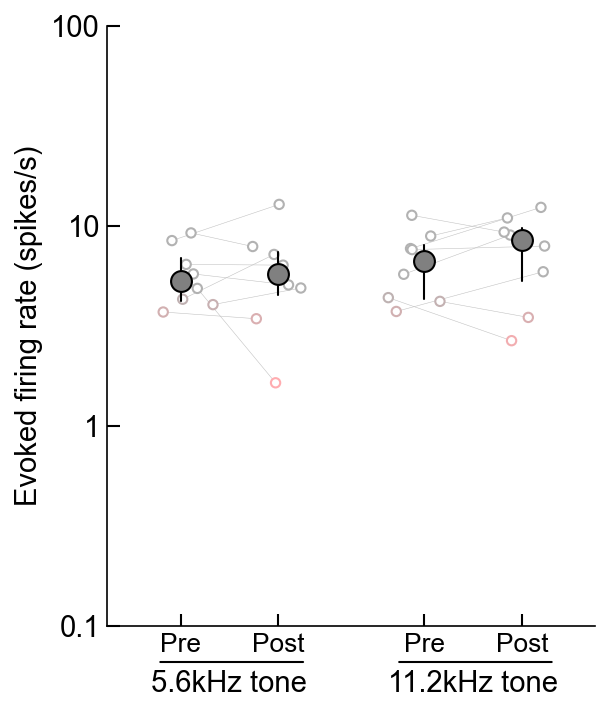

In [29]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [mean_pre_5k,mean_post_5k,mean_pre_11k,mean_post_11k]
numCon = len(data)

###
Y1,Y2 = ilep.paired_rmnan(data[0],data[1])
X1,Y1 = ilep.violin(Y1,log=True)
X2,Y2 = ilep.violin(Y2,log=True)
X1 = X1+0-switch_offset
X2 = X2+1-switch_offset
colors1 = NCR_CR_cmap( (Y1-(mn-spread/2))/ (spread) )
colors2 = NCR_CR_cmap( (Y2-(mn-spread/2))/ (spread) )

nY1,nY2 = ilep.paired_rmnan(data[2],data[3])
nX1,nY1 = ilep.violin(nY1,log=True)
nX2,nY2 = ilep.violin(nY2,log=True)
nX1 = nX1+2+switch_offset
nX2 = nX2+3+switch_offset
ncolors1 = NCR_CR_cmap( (nY1-(mn-spread/2))/ (spread) )
ncolors2 = NCR_CR_cmap( (nY2-(mn-spread/2))/ (spread) )

ax.scatter(X1, Y1, s=size, ec=colors1, fc='white', lw=1,zorder=-10)
ax.scatter(X2, Y2, s=size, ec=colors2, fc='white', lw=1,zorder=-10)
ax.plot([X1,X2],[Y1,Y2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.scatter(nX1, nY1, s=size, ec=ncolors1, fc='white', lw=1,zorder=-10)
ax.scatter(nX2, nY2, s=size, ec=ncolors2, fc='white', lw=1,zorder=-10)
ax.plot([nX1,nX2],[nY1,nY2],c=GOOD_GREY,lw=0.25,zorder=-11)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Pre','Post','Pre','Post']

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = 0.5
xtick_pos_post = 2.5
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre-switch_offset, Yval, '5.6kHz tone', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post+switch_offset, Yval, '11.2kHz tone', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.1, -stdyfrac), xycoords='axes fraction', xytext=(0.41, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.59, -stdyfrac), xycoords='axes fraction', xytext=(0.92, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC 5k vs 11k by animal V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [27]:
X,Y = ilep.paired_rmnan(mean_pre_5k,mean_post_5k)
wilcoxon(X,Y)

WilcoxonResult(statistic=18.0, pvalue=1.0)

In [28]:
X,Y = ilep.paired_rmnan(mean_pre_11k,mean_post_11k)
wilcoxon(X,Y)

WilcoxonResult(statistic=9.0, pvalue=0.25)

In [68]:
animals

array(['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56',
       'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15',
       'DS_19'], dtype='<U6')

In [66]:
animals_that_learned

['BS_40', 'BS_41', 'BS_42', 'BS_70', 'BS_72', 'BS_108', 'DS_15', 'DS_19']

In [69]:
animals_that_learned = []
days_to_learn = []
sig_prepost = []
pval_prepost = []
deltamean_prepost = []

days_to_learn_sig = []
days_to_learn_nonsig = []

for animal in animals:
    if not hasattr(learning_phases[animal],'post_expert_days') or len(learning_phases[animal].post_expert_days)==0:
        continue
    if len(switch_FR_by_animal[animal].switch_pre_FR_11k)==0 or len(switch_FR_by_animal[animal].switch_post_FR_11k)==0:
        continue

    
    animals_that_learned.append(animal)
    days_to_learn.append(np.min(learning_phases[animal].post_expert_days) - animalBehaviors[animal].reversal)
    
    pval = mannwhitneyu(switch_FR_by_animal[animal].switch_pre_FR_11k,switch_FR_by_animal[animal].switch_post_FR_11k).pvalue
    pval_prepost.append(pval)
    sig_prepost.append(pval <= 0.05)

    deltamean_prepost.append(  np.nanmean(switch_FR_by_animal[animal].switch_post_FR_5k)  -  np.nanmean(switch_FR_by_animal[animal].switch_pre_FR_5k)   )

BS_40
BS_41
BS_42
BS_49
BS_51
BS_56
BS_59
BS_67
BS_70
BS_72
BS_87
BS_108
DS_15
DS_19


In [47]:
days_to_learn

[12, 10, 8, 10, 13, 9, 10, 11]

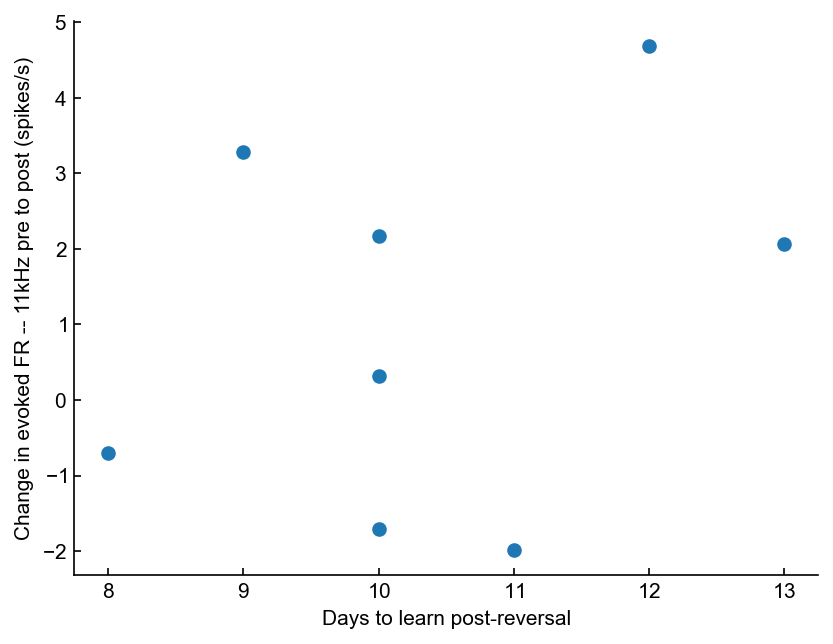

In [54]:
plt.scatter(days_to_learn,deltamean_prepost)
plt.ylabel('Change in evoked FR -- 11kHz pre to post (spikes/s)')
plt.xlabel('Days to learn post-reversal')
plt.savefig('D:\\Change in FR vs learning days 11kHz.pdf')

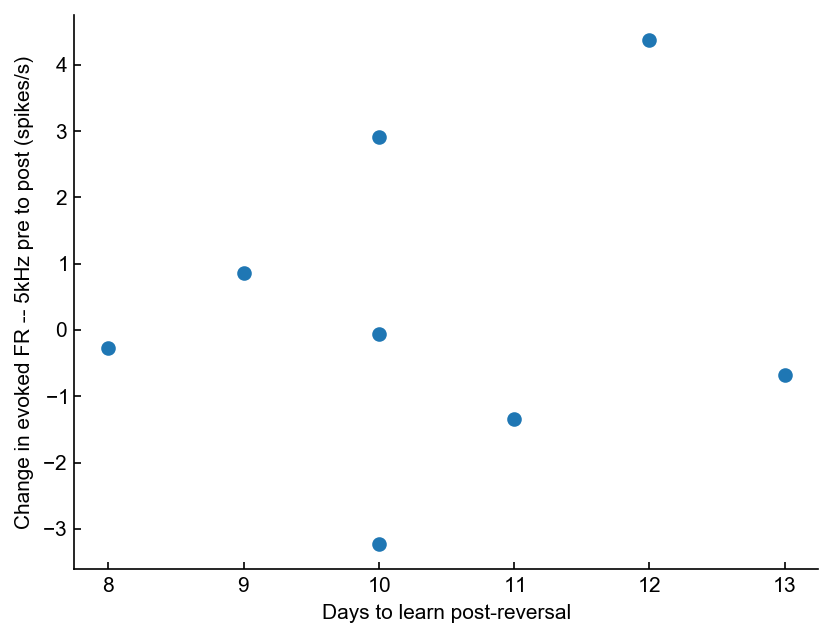

In [57]:
plt.scatter(days_to_learn,deltamean_prepost)
plt.ylabel('Change in evoked FR -- 5kHz pre to post (spikes/s)')
plt.xlabel('Days to learn post-reversal')
plt.savefig('D:\\Change in FR vs learning days 5kHz.pdf')

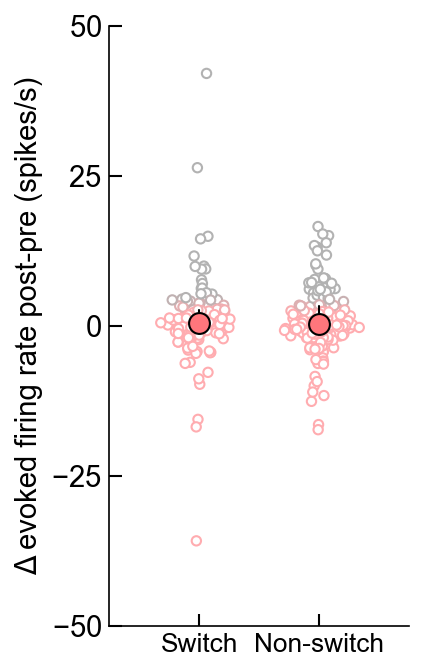

In [172]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0#.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [switch_post_FR-switch_pre_FR,non_switch_post_FR-non_switch_pre_FR]
labels = ['Switch','Non-switch']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,1]))]
X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
#X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)
# ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Switch','Non-switch']

ax.set_ylim([-50,50])
ax.set_yticks([-50,-25,0,25,50])
# ax.set_yticks([0.1,1,10,100])
# ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Δ evoked firing rate post-pre (spikes/s)')

ax.set_xlim([-0.75-switch_offset,1.75+switch_offset])
ax.set_xticks([0-switch_offset,1+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Non-switch', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC switch vs control delta V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [ ]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0#.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [switch_post_FR_bl-switch_pre_FR_bl,non_switch_post_FR_bl-non_switch_pre_FR_bl]
labels = ['Switch','Non-switch']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,1]))]
X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
#X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)
# ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Switch','Non-switch']

ax.set_ylim([-50,50])
ax.set_yticks([-50,-25,0,25,50])
# ax.set_yticks([0.1,1,10,100])
# ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Δ spontaneous iring rate post-pre (spikes/s)')

ax.set_xlim([-0.75-switch_offset,1.75+switch_offset])
ax.set_xticks([0-switch_offset,1+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Switch', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'Non-switch', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC baseline switch vs control delta V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# False alarm rate vs false alarn modulation

In [28]:
reversal_day_falarm_rate_pre = []
reversal_day_falarm_rate_post = []
reversal_day_mean_falarm_pre = []
reversal_day_mean_falarm_post = []
reversal_day_mean_off_difference = []

for animal in animals:
    if not hasattr(animalBehaviors[animal],'reversal') or not np.isfinite(animalBehaviors[animal].reversal):
        continue

    FR_mod_pre = []
    FR_mod_post = []
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)
        if sessionfile.meta.animal != animal:
            continue
        if sessionfile.meta.day_of_training != animalBehaviors[animal].reversal:
            continue
            
        

1829it [00:29, 62.18it/s] 
1829it [00:29, 61.44it/s] 
1829it [00:30, 60.96it/s] 
1829it [00:30, 60.76it/s] 
1829it [00:30, 60.58it/s] 
1829it [00:30, 59.93it/s] 
1829it [00:30, 60.93it/s] 
1829it [00:31, 57.20it/s] 
1829it [00:30, 60.71it/s] 
1829it [00:29, 61.31it/s] 
1829it [00:29, 61.05it/s] 
1829it [00:30, 60.04it/s] 
1829it [00:29, 61.59it/s] 
1829it [00:30, 60.80it/s] 
1829it [00:29, 61.75it/s] 


In [29]:
go_5k_pre = []
go_5k_post = []
nogo_5k_pre = []
nogo_5k_post = []
go_11k_pre = []
go_11k_post = []
nogo_11k_pre = []
nogo_11k_post = []

for animal in animals:
    day = animalBehaviors[animal].reversal
    outcomes = animalBehaviors[animal].sessions[day].outcomes.values
    
    outcomes_pre = outcomes[range(200)]
    outcomes_post = outcomes[range(200,len(outcomes))]
    
    print(f"{len(outcomes)} - ({len(outcomes_pre)}+{len(outcomes_post)}) = {len(outcomes)-len(outcomes_pre)-len(outcomes_post)}")
    
    go_11k_pre.append(np.mean(outcomes_pre==1))
    nogo_11k_pre.append(np.mean(outcomes_pre==2))
    go_5k_pre.append(np.mean(outcomes_pre==3))
    nogo_5k_pre.append(np.mean(outcomes_pre==4))
    
    go_5k_post.append(np.mean(outcomes_post==1))
    nogo_5k_post.append(np.mean(outcomes_post==2))
    go_11k_post.append(np.mean(outcomes_post==3))
    nogo_11k_post.append(np.mean(outcomes_post==4))

511 - (200+311) = 0
367 - (200+167) = 0
500 - (200+300) = 0
400 - (200+200) = 0
340 - (200+140) = 0
411 - (200+211) = 0
477 - (200+277) = 0
600 - (200+400) = 0
600 - (200+400) = 0
333 - (200+133) = 0
600 - (200+400) = 0
390 - (200+190) = 0
435 - (200+235) = 0
400 - (200+200) = 0
506 - (200+306) = 0


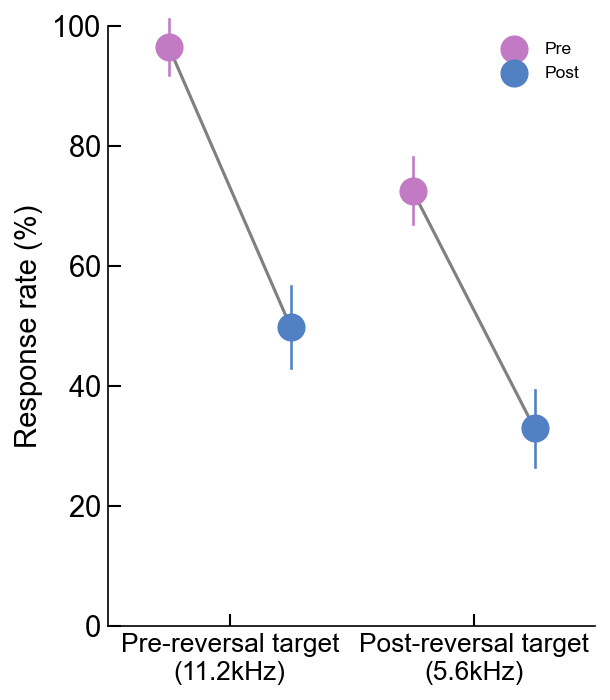

In [45]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0#.25
prepost_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
    
###
    
beh_data = [go_11k_pre,go_11k_post,go_5k_pre,go_5k_post,nogo_11k_pre,nogo_11k_post,nogo_5k_pre,nogo_5k_post]
data_mean = [np.mean(d)*200 for d in beh_data]
data_sem = [sem(d)*200 for d in beh_data]

ax.scatter([0-prepost_offset],[data_mean[0]],color=PHASE_COLORS[1],s=summary_size,lw=summary_width,label='Pre')
ax.scatter([0+prepost_offset],[data_mean[1]],color=PHASE_COLORS[4],s=summary_size,lw=summary_width,label='Post')
ax.scatter([1-prepost_offset],[data_mean[2]],color=PHASE_COLORS[1],s=summary_size,lw=summary_width)
ax.scatter([1+prepost_offset],[data_mean[3]],color=PHASE_COLORS[4],s=summary_size,lw=summary_width)

ax.plot([0-prepost_offset,0-prepost_offset],[data_mean[0]-data_sem[0],data_mean[0]+data_sem[0]],color=PHASE_COLORS[1],lw=summary_width,clip_on=False)
ax.plot([1-prepost_offset,1-prepost_offset],[data_mean[2]-data_sem[2],data_mean[2]+data_sem[2]],color=PHASE_COLORS[1],lw=summary_width)

ax.plot([0+prepost_offset,0+prepost_offset],[data_mean[1]-data_sem[1],data_mean[1]+data_sem[1]],color=PHASE_COLORS[4],lw=summary_width)
ax.plot([1+prepost_offset,1+prepost_offset],[data_mean[3]-data_sem[3],data_mean[3]+data_sem[3]],color=PHASE_COLORS[4],lw=summary_width)

ax.plot([0-prepost_offset,0+prepost_offset],[data_mean[0],data_mean[1]],color='grey',zorder=-10)
ax.plot([1-prepost_offset,1+prepost_offset],[data_mean[2],data_mean[3]],color='grey',zorder=-10)

################################################################################################################
labels = ['Pre-reversal target\n(11.2kHz)','Post-reversal target\n(5.6kHz)']

ax.set_ylim([0,100])
# ax.set_yticks([-50,-25,0,25,50])
# ax.set_yticks([0.1,1,10,100])
# ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Response rate (%)')

ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.045, -stdyfrac), xycoords='axes fraction', xytext=(0.465, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

lgd = ax.legend(frameon=False,loc='upper right')

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Switch day changes in behavior tone response rate V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [31]:
# print(wilcoxon(beh_data[0],beh_data[1]))
# print(wilcoxon(beh_data[2],beh_data[3]))
# print(wilcoxon(beh_data[4],beh_data[5]))
# print(wilcoxon(beh_data[6],beh_data[7]))

print(ttest_rel(beh_data[0],beh_data[1]))
print(ttest_rel(beh_data[2],beh_data[3]))
# print(ttest_rel(beh_data[4],beh_data[5]))
# print(ttest_rel(beh_data[6],beh_data[7]))

Ttest_relResult(statistic=6.15966450585697, pvalue=2.4778167768229466e-05)
Ttest_relResult(statistic=5.625994059443351, pvalue=6.251631832941748e-05)


In [48]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0#.25
prepost_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
    
###
    
beh_data = [go_11k_pre,go_5k_post,nogo_11k_pre,nogo_5k_post  ,  go_5k_pre,go_11k_post,nogo_5k_pre,nogo_11k_post]
data_mean = [np.mean(d)*100 for d in beh_data]
data_sem = [sem(d)*100 for d in beh_data]

ax.scatter([0-prepost_offset],[data_mean[0]],color=PHASE_COLORS[1],s=summary_size,lw=summary_width,label='Pre')
ax.scatter([0+prepost_offset],[data_mean[1]],color=PHASE_COLORS[4],s=summary_size,lw=summary_width,label='Post')
ax.scatter([1-prepost_offset],[data_mean[2]],color=PHASE_COLORS[1],s=summary_size,lw=summary_width)
ax.scatter([1+prepost_offset],[data_mean[3]],color=PHASE_COLORS[4],s=summary_size,lw=summary_width)

ax.scatter([2-prepost_offset],[data_mean[4]],color=PHASE_COLORS[1],s=summary_size,lw=summary_width)
ax.scatter([2+prepost_offset],[data_mean[5]],color=PHASE_COLORS[4],s=summary_size,lw=summary_width)
ax.scatter([3-prepost_offset],[data_mean[6]],color=PHASE_COLORS[1],s=summary_size,lw=summary_width)
ax.scatter([3+prepost_offset],[data_mean[7]],color=PHASE_COLORS[4],s=summary_size,lw=summary_width)

ax.plot([0-prepost_offset,0-prepost_offset],[data_mean[0]-data_sem[0],data_mean[0]+data_sem[0]],color=PHASE_COLORS[1],lw=summary_width,clip_on=False)
ax.plot([1-prepost_offset,1-prepost_offset],[data_mean[2]-data_sem[2],data_mean[2]+data_sem[2]],color=PHASE_COLORS[1],lw=summary_width)
ax.plot([2-prepost_offset,2-prepost_offset],[data_mean[4]-data_sem[4],data_mean[4]+data_sem[4]],color=PHASE_COLORS[1],lw=summary_width)
ax.plot([3-prepost_offset,3-prepost_offset],[data_mean[6]-data_sem[6],data_mean[6]+data_sem[6]],color=PHASE_COLORS[1],lw=summary_width)

ax.plot([0+prepost_offset,0+prepost_offset],[data_mean[1]-data_sem[1],data_mean[1]+data_sem[1]],color=PHASE_COLORS[4],lw=summary_width)
ax.plot([1+prepost_offset,1+prepost_offset],[data_mean[3]-data_sem[3],data_mean[3]+data_sem[3]],color=PHASE_COLORS[4],lw=summary_width)
ax.plot([2+prepost_offset,2+prepost_offset],[data_mean[5]-data_sem[5],data_mean[5]+data_sem[5]],color=PHASE_COLORS[4],lw=summary_width)
ax.plot([3+prepost_offset,3+prepost_offset],[data_mean[7]-data_sem[7],data_mean[7]+data_sem[7]],color=PHASE_COLORS[4],lw=summary_width)

ax.plot([0-prepost_offset,0+prepost_offset],[data_mean[0],data_mean[1]],color='grey',zorder=-10)
ax.plot([1-prepost_offset,1+prepost_offset],[data_mean[2],data_mean[3]],color='grey',zorder=-10)
ax.plot([2-prepost_offset,2+prepost_offset],[data_mean[4],data_mean[5]],color='grey',zorder=-10)
ax.plot([3-prepost_offset,3+prepost_offset],[data_mean[6],data_mean[7]],color='grey',zorder=-10)

################################################################################################################
labels = ['Hit','Miss','F. alarm','C. reject']

ax.set_ylim([0,50])
# ax.set_yticks([-50,-25,0,25,50])
# ax.set_yticks([0.1,1,10,100])
# ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Trial outcome rate (%)')

ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = 0.5
# xtick_pos_post = 2.5
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_pre-switch_offset, Yval, 'Go', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post+switch_offset, Yval, 'No-go', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.045, -stdyfrac), xycoords='axes fraction', xytext=(0.465, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.965, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

lgd = ax.legend(frameon=False,loc='upper right')

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,lgd]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Switch day changes in behavior trial outcomes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [33]:
# print(wilcoxon(beh_data[0],beh_data[1]))
# print(wilcoxon(beh_data[2],beh_data[3]))
# print(wilcoxon(beh_data[4],beh_data[5]))
# print(wilcoxon(beh_data[6],beh_data[7]))

print(ttest_rel(beh_data[0],beh_data[1]))
print(ttest_rel(beh_data[2],beh_data[3]))
print(ttest_rel(beh_data[4],beh_data[5]))
print(ttest_rel(beh_data[6],beh_data[7]))

Ttest_relResult(statistic=7.878110684989536, pvalue=1.6366976165765111e-06)
Ttest_relResult(statistic=-8.05698371320037, pvalue=1.2607331561875124e-06)
Ttest_relResult(statistic=3.1311400715809374, pvalue=0.007362504435751681)
Ttest_relResult(statistic=-2.5003937898454778, pvalue=0.025447297269214318)


In [33]:
beh_data[4]

[0.39,
 0.23,
 0.135,
 0.485,
 0.395,
 0.46,
 0.39,
 0.46,
 0.375,
 0.385,
 0.445,
 0.39,
 0.325,
 0.42,
 0.155]

In [34]:
beh_data[5]

[0.1864951768488746,
 0.33532934131736525,
 0.17666666666666667,
 0.46,
 0.09285714285714286,
 0.13744075829383887,
 0.16606498194945848,
 0.4475,
 0.3825,
 0.20300751879699247,
 0.475,
 0.21052631578947367,
 0.19574468085106383,
 0.125,
 0.14052287581699346]

In [35]:
beh_data[6]

[0.095,
 0.25,
 0.355,
 0.01,
 0.09,
 0.025,
 0.1,
 0.035,
 0.115,
 0.1,
 0.04,
 0.105,
 0.165,
 0.065,
 0.33]

In [36]:
beh_data[7]

[0.2765273311897106,
 0.10778443113772455,
 0.30666666666666664,
 0.02,
 0.34285714285714286,
 0.3222748815165877,
 0.2996389891696751,
 0.03,
 0.0925,
 0.23308270676691728,
 0.0,
 0.23157894736842105,
 0.2723404255319149,
 0.315,
 0.31699346405228757]

In [39]:
beh_data2 = np.array(beh_data)

In [40]:
beh_data2[0]+beh_data2[1]+beh_data2[2]+beh_data2[3]

array([1.05197749, 1.07688623, 1.02666667, 1.025     , 1.07928571,
       1.05528436, 1.04429603, 1.0275    , 1.035     , 1.07890977,
       1.04      , 1.06289474, 1.04191489, 1.075     , 1.05748366])

In [41]:
beh_data2[4]+beh_data2[5]+beh_data2[6]+beh_data2[7]

array([0.94802251, 0.92311377, 0.97333333, 0.975     , 0.92071429,
       0.94471564, 0.95570397, 0.9725    , 0.965     , 0.92109023,
       0.96      , 0.93710526, 0.95808511, 0.925     , 0.94251634])

In [42]:
beh_data2[4]+beh_data[6]

array([0.485, 0.48 , 0.49 , 0.495, 0.485, 0.485, 0.49 , 0.495, 0.49 ,
       0.485, 0.485, 0.495, 0.49 , 0.485, 0.485])

In [43]:
beh_data2[5]+beh_data[7]

array([0.46302251, 0.44311377, 0.48333333, 0.48      , 0.43571429,
       0.45971564, 0.46570397, 0.4775    , 0.475     , 0.43609023,
       0.475     , 0.44210526, 0.46808511, 0.44      , 0.45751634])